In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier # Load k-NN from sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import datetime as dt


from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix

import collections
from statsmodels.distributions.empirical_distribution import ECDF

import unittest

from mesa.time import RandomActivation, SimultaneousActivation, BaseScheduler
from mesa.datacollection import DataCollector
from mesa import Model, Agent
from mesa.batchrunner import BatchRunner, BatchRunnerMP


from sklearn.svm import SVC, LinearSVC
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from category_encoders.binary import BinaryEncoder
from itertools import combinations
import seaborn as sns
import pathos
import multiprocessing

# Preprocessing and Feature Engineering

## Loading and merging data frames

In [2]:
severity_scores_df = pd.read_csv('severity_scores_df.csv')
severity_scores_df=severity_scores_df.drop_duplicates(subset='subject_id',keep='first').sort_values(by='subject_id')

# Removing redundant columns Subject_ID and HADM_ID
severity_scores_df = severity_scores_df.drop(['subject_id','hadm_id','icustay_expire_flag','ICUSTAY_AGE_GROUP',
                                              'OASIS', 'OASIS_PROB','age_score','preiculos_score', 'gcs_score',
                                                'heartrate_score', 'meanbp_score',
                                               'resprate_score', 'temp_score',
                                               'UrineOutput_score', 'mechvent_score',
                                               'electivesurgery_score', 'SAPS', 'resp_score', 'vent_score',
                                               'hematocrit_score', 'glucose_score', 'SAPSII', 'SAPSII_PROB',
                                               'PaO2FiO2_score', 'bilirubin_score', 'comorbidity_score',
                                               'admissiontype_score', 'SOFA','age'], axis=1) #,'INTIME'

In [3]:
main_df2 = pd.read_csv("main_df2.csv")

# Remove duplicate 'DEATHRATE_INT_CAT__' columns
# main_df2 = main_df2.drop(['DEATHRATE_INT_CAT__1.0_x', 'DEATHRATE_INT_CAT__2.0_x'],axis=1)
main_df2 = main_df2.rename({'DEATHRATE_INT_CAT__1.0_y':'DEATHRATE_INT_CAT__1.0',
                            'DEATHRATE_INT_CAT__2.0_y':'DEATHRATE_INT_CAT__2.0'},axis=1)

In [4]:
df = main_df2.merge(severity_scores_df, how='left', left_on = 'ICUSTAY_ID' ,right_on='icustay_id')

vitals_df = pd.read_csv("vitals_df.csv")
df = df.merge(vitals_df, how='inner', on='ICUSTAY_ID')#icustay_id

## Encoding dummy variables

In [5]:
# Binary Encoding

diagnosis_encoder = BinaryEncoder()
diagnosis_binary = diagnosis_encoder.fit_transform(df['ICD9_CODE'].astype(str))

# Create dummies for Gender
gender_df =pd.get_dummies(df ['GENDER'],prefix='gender_', drop_first=True)

# Create dummies for Age Group
age_group_df =pd.get_dummies(df ['ICUSTAY_AGE_GROUP'], prefix='age_group_', drop_first=True)

# Create dummies for Admission Type
admtype_df =pd.get_dummies(df ['ADMISSION_TYPE'],prefix='ADMISSION_TYPE_', drop_first=True)

# Create dummies for Insurance Type
instype_df =pd.get_dummies(df ['INSURANCE'],prefix='INSURANCE_TYPE_', drop_first=True)

# Creat dummies for car_unit
care_unit = pd.get_dummies(df ['CURR_CAREUNIT'], prefix='careunit_', drop_first=True)

# Merge all encoded variables
df2 = pd.concat([df,gender_df,age_group_df,admtype_df,instype_df,care_unit], axis=1) #, diagnosis_binary


## Reformatting Time Variables

In [6]:
# Dealing with time variables

df2['OUTTIME'] = pd.to_datetime(df2['OUTTIME'],format='%Y-%m-%d')
df2['INTIME'] = pd.to_datetime(df2['INTIME'],format='%Y-%m-%d')
# df2['DOB'] = pd.to_datetime(df2['DOB'],format='%Y-%m-%d')

# Shift timescale
df2['INTIME_ACTUAL']= df2['INTIME']+ pd.to_timedelta(df2['DIFF'],unit='D')
df2['OUTTIME_ACTUAL']= df2['OUTTIME']+ pd.to_timedelta(df2['DIFF'],unit='D')
# df2['DOB_ACTUAL']= df2['DOB']+ pd.to_timedelta(df2['DIFF'],unit='D')

In [7]:
df3 = df2.drop(['icustay_id', 'hospital_expire_flag',
               'ICUSTAY_ID', 'INTIME', 'OUTTIME', 'DIFF',
               'LAST_WARDID', 'GENDER','DOB', 'ICD9_CODE', 'SHORT_TITLE',
               'LONG_TITLE', 'SEQ_NUM', 'DEATHTIME','ICUSTAY_AGE_GROUP',
               'INTIME_ACTUAL','OUTTIME_ACTUAL',"ADMISSION_TYPE",'INSURANCE','CURR_CAREUNIT'], axis=1)

#'SUBJECT_ID', 'HADM_ID', 

df2 (before key information is dropped) will be used for later analyses

# ABM

## Daily snapshots

In [8]:
# Only takes the first three characters from ICD9_Code as the rest is only decimal points 
#(https://mimic.physionet.org/mimictables/diagnoses_icd/)
df2['ICD9_CODE'] = df2['ICD9_CODE'].apply(lambda x: x[:3])
# Converts ICD9 Codes of type "O" to integer in case string contains only digits, else None
df2['ICD9_CODE'] = df2['ICD9_CODE'].apply(lambda x: int(x) if str(x).isdigit() else None)

def f(x):
    if x['ICD9_CODE'] > 1 and x['ICD9_CODE'] < 139: return 'Infectious And Parasitic Diseases'
    elif x['ICD9_CODE'] > 140 and x['ICD9_CODE'] < 239: return 'Neoplasms'
    elif x['ICD9_CODE'] > 240 and x['ICD9_CODE'] < 279: return 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders'
    elif x['ICD9_CODE'] > 280 and x['ICD9_CODE'] < 289: return 'Diseases Of The Blood And Blood-Forming Organs'
    elif x['ICD9_CODE'] > 290 and x['ICD9_CODE'] < 319: return 'Mental Disorders'
    elif x['ICD9_CODE'] > 320 and x['ICD9_CODE'] < 389: return 'Diseases Of The Nervous System And Sense Organs'
    elif x['ICD9_CODE'] > 390 and x['ICD9_CODE'] < 459: return 'Diseases Of The Circulatory System'
    elif x['ICD9_CODE'] > 460 and x['ICD9_CODE'] < 519: return 'Diseases Of The Respiratory System'
    elif x['ICD9_CODE'] > 520 and x['ICD9_CODE'] < 579: return 'Diseases Of The Digestive System'
    elif x['ICD9_CODE'] > 580 and x['ICD9_CODE'] < 629: return 'Diseases Of The Genitourinary System'
    elif x['ICD9_CODE'] > 630 and x['ICD9_CODE'] < 679: return 'Complications Of Pregnancy, Childbirth, And The Puerperium'
    elif x['ICD9_CODE'] > 680 and x['ICD9_CODE'] < 709: return 'Diseases Of The Skin And Subcutaneous Tissue'
    elif x['ICD9_CODE'] > 710 and x['ICD9_CODE'] < 739: return 'Diseases Of The Musculoskeletal System And Connective Tissue'
    elif x['ICD9_CODE'] > 740 and x['ICD9_CODE'] < 759: return 'Congenital Anomalies'
    elif x['ICD9_CODE'] > 760 and x['ICD9_CODE'] < 779: return 'Certain Conditions Originating In The Perinatal Period'
    elif x['ICD9_CODE'] > 780 and x['ICD9_CODE'] < 799: return 'Symptoms, Signs, And Ill-Defined Conditions'
    elif x['ICD9_CODE'] > 800 and x['ICD9_CODE'] < 999: return 'Injury And Poisoning'
    else: return "Other"
df2['ICD9_CODE_CAT'] = df2.apply(f, axis=1)


In [9]:
icustay_ids = [f for f in df2['ICUSTAY_ID']]
intimes = [t.date() for t in df2['INTIME_ACTUAL']]
outtimes = [t.date() for t in df2['OUTTIME_ACTUAL']]
expire_flags = [f for f in df2['HOSPITAL_EXPIRE_FLAG']]

## Loading snapshots dataframe

In [10]:
df_snapshots = pd.read_csv("df_snapshots.csv")
df_snapshots = df_snapshots.reset_index()
df_snapshots = df_snapshots.drop('index',axis=1)
df_snapshots['icustay_id']=np.int64(df_snapshots['icustay_id'])

In [11]:
df2 = df2.drop('icustay_id',axis=1)

In [12]:
df3 = df2.merge(df_snapshots, 'outer', left_on='ICUSTAY_ID', right_on='icustay_id').drop('icustay_id',axis=1)

In [13]:
# Binary Encoding
diagnosis_encoder = BinaryEncoder()
diagnosis_binary = diagnosis_encoder.fit_transform(df3['ICD9_CODE_CAT'].astype(str))
df3 = pd.concat([df3,diagnosis_binary], axis=1) #, diagnosis_binary

## Loading dataframe with caregivers_count

In [14]:
caregivers_count_df = pd.read_csv("caregivers_count_df.csv")

In [15]:
caretime_doctors = [d/p for d,p in zip(caregivers_count_df['COUNT_DOCTORS'], caregivers_count_df['COUNT_PATIENTS'])]
caretime_nurses = [n/p for n,p in zip(caregivers_count_df['COUNT_NURSES'], caregivers_count_df['COUNT_PATIENTS'])]

In [16]:
caretime_df = caregivers_count_df[['DATE']]
caretime_df['caretime_doctors'] = caretime_doctors
caretime_df['caretime_nurses'] = caretime_nurses

/Users/vivek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/vivek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
# df3 = df3.merge(caregivers_count_df, how='left', left_on='date',right_on="DATE")
df3 = df3.merge(caretime_df, how='left', left_on='date',right_on="DATE")

In [18]:
cum_caretime = df3[['ICUSTAY_ID','DATE','caretime_doctors','caretime_nurses']].groupby(['ICUSTAY_ID','DATE']).sum().groupby('ICUSTAY_ID').cumsum()
cum_caretime = pd.DataFrame(cum_caretime.to_records())
cum_caretime.columns = ['ICUSTAY_ID', 'DATE', 'cum_caretime_doctors', 'cum_caretime_nurses']
df3 = df3.merge(cum_caretime,how='inner',on=['ICUSTAY_ID','DATE'])

## Loading procedures dataframe

In [19]:
procedures_df = pd.read_csv("procedures.csv")

In [20]:
cols = procedures_df.columns.tolist()
cols.append('days_since_admission')
procedures_df2 = pd.DataFrame(columns = cols)

for i in range(procedures_df.shape[0]):
    entry_i = procedures_df.loc[[i]]
    df_i = procedures_df.loc[i]
    all_i = pd.concat([entry_i]*(df_i['DAYSIN_END']-df_i['DAYSIN_START']+1))
    days = np.arange(df_i['DAYSIN_START'],df_i['DAYSIN_END']+1)
    all_i['days_since_admission'] = days
    procedures_df2 = pd.concat([procedures_df2, all_i])

In [21]:
procedures_df3 = procedures_df2.reset_index().drop(['index','ITEMID','LABEL','DAYSIN_START','DAYSIN_END'],axis=1)
procedures_dummies = pd.get_dummies(procedures_df3['ORDERCATEGORYNAME'],prefix='procedure')
procedures_df4 = pd.concat([procedures_df3,procedures_dummies],axis=1)
procedures_df4 = procedures_df4.drop(['SUBJECT_ID','HADM_ID','ORDERCATEGORYNAME'],axis=1)

In [22]:
procedures_df4['ICUSTAY_ID'] = procedures_df4['ICUSTAY_ID'].astype('int64')
procedures_df4['days_since_admission'] = procedures_df4['days_since_admission'].astype('int64')
procedures_df4 = procedures_df4.rename(columns={'procedure_Significant Events':'procedure_SignificantEvents'})

In [23]:
procedures_df5 = procedures_df4.groupby(['ICUSTAY_ID','days_since_admission']).sum().reset_index()
procedures_df5['procedure_SignificantEvents'] = procedures_df5['procedure_SignificantEvents'].where(procedures_df5['procedure_SignificantEvents'] < 1, 1)
procedures_df5['procedure_Ventilation'] = procedures_df5['procedure_Ventilation'].where(procedures_df5['procedure_Ventilation'] < 1, 1)

In [24]:
df4 = df3.merge(procedures_df5,how='left',on=['ICUSTAY_ID','days_since_admission'])
df4[['procedure_SignificantEvents', 'procedure_Ventilation']] = df4[['procedure_SignificantEvents','procedure_Ventilation']].fillna(value=0)


In [25]:
# For simulations
df6 = df4.copy()

In [26]:
df4 = df4.drop(['HOSPITAL_EXPIRE_FLAG','hospital_expire_flag',
               'ICUSTAY_ID', 'INTIME', 'OUTTIME', 'DIFF',
               'LAST_WARDID', 'GENDER','DOB', 'ICD9_CODE', 'SHORT_TITLE',
               'LONG_TITLE', 'SEQ_NUM', 'DEATHTIME','ICUSTAY_AGE_GROUP',
               'ICD9_CODE_CAT','date',
               'INTIME_ACTUAL', 'OUTTIME_ACTUAL',"CURR_CAREUNIT","INSURANCE","ADMISSION_TYPE","DATE","LOS",
               'caretime_doctors','caretime_nurses'], axis=1)

#'SUBJECT_ID', 'HADM_ID', 'subject_id', 'hadm_id'

In [27]:
# Prepare variables for model
y=df4['out_flag']
X=df4.drop(['out_flag'],axis=1)

# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.1)

In [28]:
orig_index = X_train.index

In [29]:
imp_iter = IterativeImputer(random_state=0)
imp_iter.fit(X_train)
X_train = imp_iter.transform(X_train)

In [30]:
X_train = pd.DataFrame(X_train)
X_train.columns = df4.drop(['out_flag'],axis=1).columns

In [31]:
X_train.index = orig_index

In [32]:
X_test = imp_iter.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = df4.drop(['out_flag'],axis=1).columns

In [33]:
import copy
y_train_orig = copy.deepcopy(y_train)
X_train_orig = copy.deepcopy(X_train)

In [34]:
# Remove some entries of class 0
import random
index_0 = [i for i in y_train[y_train == 0].index]
index_1 = [i for i in y_train[y_train == 1].index]
index_neg1 = [i for i in y_train[y_train == -1].index]
samp = random.sample(index_0, len(index_1))
samp_neg1 = random.sample(index_neg1, len(index_1))
samp.extend(samp_neg1)
samp.extend(index_1)
X_train = X_train.loc[samp,]
y_train = y_train.loc[samp,]

In [35]:
# Choose columns to be scaled for X_train
scale_columns = ['age','preiculos', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp',
       'urineoutput', 'respiration',
       'coagulation', 'liver', 'cardiovascular', 'cns', 'renal',
                'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean','days_since_admission',
                'cum_caretime_doctors','cum_caretime_nurses'] 
scale_df = X_train[scale_columns]

# Seperate the non-scaled columns (dummies) X_train
temp = X_train.drop(scale_columns,axis=1)
temp = temp.reset_index(drop=True)

# Apply actual scaling to X_train
scaler = preprocessing.StandardScaler().fit(scale_df) 
scale_tr = scaler.transform(scale_df) 
scale_df = pd.DataFrame(scale_tr,columns=scale_columns)

# Add the non-scaled and scaled dataframes back together
X_train = pd.concat([scale_df,temp], axis=1) 

#Choose columns to be scaled for X_test
scale_df2 = X_test[scale_columns]

# Seperate the non-scaled columns (dummies) X_test
temp2 = X_test.drop(scale_columns,axis=1)
temp2 = temp2.reset_index(drop=True)

# Apply actual scaling to X_test
# scaler2 = preprocessing.StandardScaler().fit(scale_df2) 
scale_tr2= scaler.transform(scale_df2) 
scale_df2=pd.DataFrame(scale_tr2,columns=scale_columns)

# Add the non-scaled and scaled dataframes back together X_test
X_test = pd.concat([scale_df2,temp2], axis=1) 

In [36]:
y_train = [2 if y==-1 else y for y in y_train]

## Submodel (Multi-task Prediction Model)

In [66]:
X_train_sub = X_train.copy()
y_train_sub = y_train.copy()
X_test_sub = X_test.copy()
y_test_sub = y_test.copy()

In [67]:
back_cols = ['days_since_admission','procedure_SignificantEvents', 'procedure_Ventilation',
#               'COUNT_DOCTORS', 'COUNT_NURSES', 'COUNT_PATIENTS',
            'cum_caretime_doctors','cum_caretime_nurses']
col_ord = [c for c in X_train_sub.columns if c not in back_cols]
col_ord.extend(back_cols)

In [68]:
X_train_sub = X_train_sub.loc[:,col_ord]
X_test_sub = X_test_sub.loc[:,col_ord]

In [69]:
feature_names = X_train_sub.columns

In [73]:
def reweight(pi0,pi1,pi2,q0=0.5,r0=0.5,q1=0.5,r1=0.5,q2=0.5,r2=0.5):
    tot = pi0*(q0/r0)+pi1*(q1/r1)+pi2*(q2/r2)
    w0 = pi0*(q0/r0)
    w1 = pi1*(q1/r1)
    w2 = pi2*(q2/r2)
    w0 /= tot
    w1 /= tot
    w2 /= tot
    return w0,w1,w2

In [78]:
y_train_orig = [2 if y==-1 else y for y in y_test_sub]

#Population ratios
q0 = np.sum([y==0 for y in y_train_orig])/len(y_train_orig)
q1 = np.sum([y==1 for y in y_train_orig])/len(y_train_orig)
q2 = np.sum([y==2 for y in y_train_orig])/len(y_train_orig)

r0 = 1/3 # training set
r1 = 1/3 # training set
r2 = 1/3 # training set

### Random forest

In [111]:
# IMPORTANT!!!!
# But one-hot encoding also presents two problems that are more particular to tree-based models:
# The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
# A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.

forest = RandomForestClassifier(n_estimators=20)  #Setting n_estimator to prevent overfitting
forest_fitted = forest.fit(X_train_sub, y_train_sub) 
scores = cross_val_score(forest, X_train_sub, y_train_sub, cv=5)
y_pred_forest = forest.predict(X_test_sub)
y_pred_prob = forest.predict_proba(X_test_sub)

In [112]:
# Step 5: Assess expected accuracy
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Step 6: Assess variable importance
importances = forest_fitted.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)


Accuracy: 0.64 (+/- 0.02)


procedure_Ventilation       1.000000
urineoutput                 0.623556
cum_caretime_doctors        0.608712
ICD9_CODE_CAT_3             0.597489
ICD9_CODE_CAT_5             0.583021
                              ...   
gender__M                   0.014710
age_group__65-89            0.007462
careunit__SICU              0.006672
INSURANCE_TYPE__Medicaid    0.006117
careunit__MICU              0.000000
Length: 69, dtype: float64

#### Evaluation

In [113]:
rew0 = []
rew1 = []
rew2 = []

for i in range(len(y_test_sub)):
    pi0,pi1,pi2 = y_pred_prob[i]
    w0,w1,w2 = reweight(pi0,pi1,pi2,q0,r0,q1,r1,q2,r2)
    rew0.append(w0)
    rew1.append(w1)
    rew2.append(w2)

In [114]:
pred_rew = [np.argmax([a,b,c]) for a,b,c in zip(rew0,rew1,rew2)]

In [115]:
y_test_sub = [2 if y==-1 else y for y in y_test_sub]

In [118]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test_sub, classes=[0, 1, 2])
y_pred_forest_bin = label_binarize(pred_rew, classes=[0, 1, 2])

In [119]:
from sklearn.metrics import average_precision_score

eval_models = {'rf':average_precision_score(y_test_bin, y_pred_forest_bin,average="weighted")}
eval_models

{'rf': 0.6813926800836184}

### Gradient Boosting

In [120]:
from sklearn.ensemble import GradientBoostingClassifier

In [121]:

# IMPORTANT!!!!
# But one-hot encoding also presents two problems that are more particular to tree-based models:
# The resulting sparsity virtually ensures that continuous variables are assigned higher feature importance.
# A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.

feature_names = X_train.columns
tree = GradientBoostingClassifier(n_estimators=50)  #Setting n_estimator to prevent overfitting
tree_fitted = tree.fit(X_train, y_train) 
scores = cross_val_score(tree, X_train, y_train, cv=5)
y_pred_tree = tree.predict(X_test)
y_pred_prob_tree = tree.predict_proba(X_test)


In [122]:
# Step 5: Assess expected accuracy
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Step 6: Assess variable importance
importances = tree_fitted.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.67 (+/- 0.02)


DEATHRATE_CAT__2.0             1.000000
cum_caretime_nurses            0.832544
urineoutput                    0.811364
procedure_Ventilation          0.790727
DEATHRATE_CAT__1.0             0.518546
                                 ...   
INSURANCE_TYPE__Self Pay       0.000000
procedure_SignificantEvents    0.000000
ICD9_CODE_CAT_4                0.000000
careunit__SICU                 0.000000
ICD9_CODE_CAT_3                0.000000
Length: 69, dtype: float64

#### Evaluation

In [123]:
rew0 = []
rew1 = []
rew2 = []

for i in range(len(y_test_sub)):
    pi0,pi1,pi2 = y_pred_prob_tree[i]
    w0,w1,w2 = reweight(pi0,pi1,pi2,q0,r0,q1,r1,q2,r2)
    rew0.append(w0)
    rew1.append(w1)
    rew2.append(w2)

In [124]:
pred_rew = [np.argmax([a,b,c]) for a,b,c in zip(rew0,rew1,rew2)]

In [125]:
y_test_sub = [2 if y==-1 else y for y in y_test_sub]

In [128]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test_sub, classes=[0, 1, 2])
y_pred_forest_bin = label_binarize(pred_rew, classes=[0, 1, 2])

In [130]:
from sklearn.metrics import average_precision_score

eval_models.update({'gb':average_precision_score(y_test_bin, y_pred_forest_bin,average="weighted")})
eval_models

{'rf': 0.6813926800836184, 'gb': 0.6965968978674881}

### XGB

In [601]:
# feature importance
xgb_model = xgb.XGBClassifier(objective='multi:softprob',
              learning_rate= 0.1, #so called `eta` value
              max_depth= 6,
              min_child_weight= 11,
              silent= 1,
              subsample= 0.8,
              colsample_bytree= 0.7,
              n_estimators= 50, #number of trees 
              missing=-999, #replacing missing values
              reg_lambda=1.5,
              seed= 1337)

xgb_model.fit(X_train_sub,y_train_sub)

y_pred_xgb = xgb_model.predict(X_test_sub)
y_pred_prob_xgb = xgb_model.predict_proba(X_test_sub)


In [602]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

importances = xgb_model.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.68 (+/- 0.01)


cum_caretime_doctors        1.000000
ICD9_CODE_CAT_5             0.806862
days_since_admission        0.672129
ICD9_CODE_CAT_3             0.456828
cum_caretime_nurses         0.453216
                              ...   
careunit__MICU              0.000000
DEATHRATE_CAT__1.0          0.000000
INSURANCE_TYPE__Medicaid    0.000000
age_group__65-89            0.000000
ICD9_CODE_CAT_4             0.000000
Length: 69, dtype: float32

#### Evaluation

In [603]:
rew0 = []
rew1 = []
rew2 = []

for i in range(len(y_test_sub)):
    pi0,pi1,pi2 = y_pred_prob_xgb[i]
    w0,w1,w2 = reweight(pi0,pi1,pi2,q0,r0,q1,r1,q2,r2)
    rew0.append(w0)
    rew1.append(w1)
    rew2.append(w2)

In [604]:
pred_rew = [np.argmax([a,b,c]) for a,b,c in zip(rew0,rew1,rew2)]

In [605]:
y_test_sub = [2 if y==-1 else y for y in y_test_sub]

In [608]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test_sub, classes=[0, 1, 2])
y_pred_forest_bin = label_binarize(pred_rew, classes=[0, 1, 2])

In [609]:
from sklearn.metrics import average_precision_score

eval_models.update({'xgb':average_precision_score(y_test_bin, y_pred_forest_bin,average="weighted")})
eval_models

{'rf': 0.6813926800836184,
 'gb': 0.6965968978674881,
 'xgb': 0.7075535897809753,
 'svc': 0.6956649810215869,
 'ensemble': 0.6949639007226197}

In [265]:
def prediction_xgb (X_new,rew):
    
    # Choose columns to be scaled for X_train
    scale_columns = ['age','preiculos', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp',
           'urineoutput', 'respiration',
           'coagulation', 'liver', 'cardiovascular', 'cns', 'renal',
                    'HeartRate_Min', 'HeartRate_Max',
           'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
           'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
           'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
           'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
           'Glucose_Min', 'Glucose_Max', 'Glucose_Mean','days_since_admission',
                    'cum_caretime_doctors','cum_caretime_nurses'] 
    scale_df = X_new[scale_columns]

    # Seperate the non-scaled columns (dummies) X_train
    temp = X_new.drop(scale_columns,axis=1)
    temp = temp.reset_index(drop=True)

    # Apply actual scaling to X_train
    scale_tr = scaler.transform(scale_df) 
    scale_df = pd.DataFrame(scale_tr,columns=scale_columns)

    # Add the non-scaled and scaled dataframes back together
    X_new = pd.concat([scale_df,temp], axis=1) 
    X_new = X_new.loc[:,col_ord]
    X_new = X_new.astype('float64')

    y_pred_prob = xgb_model.predict_proba(X_new)
    if rew:
        y_pred = []
        for i in range(X_new.shape[0]):
            if np.argmax(y_pred_prob[i,]) == 0:
                y_pred.append(0)
            elif np.argmax(y_pred_prob[i,]) == 1:
                y_pred.append(1)
            elif y_pred_prob[i,2] > 10*y_pred_prob[i,1]:
                y_pred.append(2)
            else:
                y_pred.append(1)
    else:
        y_pred = [np.argmax(y_pred_prob[i,]) for i in range(X_new.shape[0])]
    return(y_pred)

In [670]:
importances = xgb_model.get_booster().get_score(importance_type="gain")
importances_df = pd.DataFrame(importances.values(),importances.keys())
importances_df.sort_values(0,ascending=False).head(10)

,0
DEATHRATE_CAT__2.0,35.048599
procedure_Ventilation,28.279371
DEATHRATE_CAT__1.0,23.557163
days_since_admission,16.011197
DEATHRATE_INT_CAT__1.0,15.884585
SpO2_Min,9.181978
ADMISSION_TYPE__EMERGENCY,9.142745
urineoutput,8.774081
cum_caretime_nurses,7.887445
cardiovascular,7.437773


### SVC

In [86]:
# #Grid Search CV

# MySvc = SVC(C=1)
# grid_values = {'kernel':['rbf','linear'],
#                #'C':[0.1,0.5,1] , 
#                'gamma':[0.05, 0.1], 
#                #'decision_function_shape':['ovr','ovo'],
#                #'class_weight':['balanced',inv_weight,arith_weight]
#               } # Parameter grid here, default gamma = 1/(num features)
# grid_svc_acc = GridSearchCV(MySvc, param_grid = grid_values,scoring = 'accuracy', cv=5)
# grid_svc_acc.fit(X_train_sub, y_train_sub)

# #Best parameters
# print('Best Cost parameter : '+ str(grid_svc_acc.best_estimator_.C))
# print('Best gamma parameter : '+ str(grid_svc_acc.best_estimator_.gamma))

# # Report best Number of Neighbors
# # GridSearch_table_plot(grid_svc_acc, "C", negative=False, display_all_params=False)

Best Cost parameter : 1
Best gamma parameter : 0.05


best parameters: {'gamma': 0.05, 'kernel': 'rbf'}
best score:      0.58843 (+/-0.01751)


,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.05,rbf,"{'gamma': 0.05, 'kernel': 'rbf'}",0.567976,0.610272,0.601208,0.594949,0.567677,0.588425,0.017506,1
1,0.05,linear,"{'gamma': 0.05, 'kernel': 'linear'}",0.582075,0.585096,0.589124,0.588889,0.583838,0.585804,0.002786,2
3,0.1,linear,"{'gamma': 0.1, 'kernel': 'linear'}",0.582075,0.585096,0.589124,0.588889,0.583838,0.585804,0.002786,2
2,0.1,rbf,"{'gamma': 0.1, 'kernel': 'rbf'}",0.542800,0.568983,0.567976,0.559596,0.524242,0.552732,0.017047,4


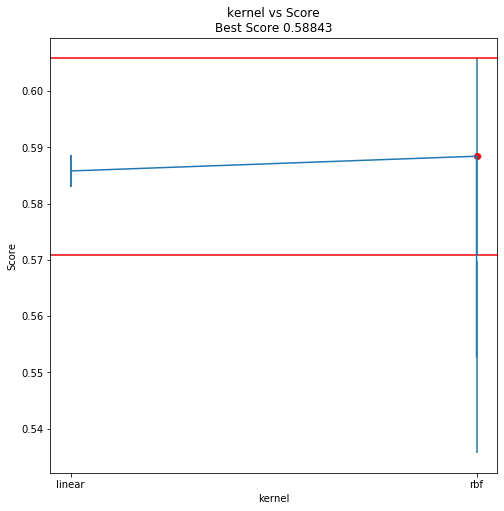

In [88]:
# from utils.helper_functions import *

# GridSearch_table_plot(grid_svc_acc, "kernel", negative=False, display_all_params=False)

In [396]:
classifier = SVC(kernel ='rbf', C=1, gamma=0.05, probability=True)
classifier.fit(X_train_sub, y_train_sub)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [397]:
y_pred = classifier.predict(X_test_sub)
y_pred_prob = classifier.predict_proba(X_test_sub)

In [398]:
def prediction_svm (X_new,rew):
    
    # Choose columns to be scaled for X_train
    scale_columns = ['age','preiculos', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp',
           'urineoutput', 'respiration',
           'coagulation', 'liver', 'cardiovascular', 'cns', 'renal',
                    'HeartRate_Min', 'HeartRate_Max',
           'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
           'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
           'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
           'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
           'Glucose_Min', 'Glucose_Max', 'Glucose_Mean','days_since_admission',
                    'cum_caretime_doctors','cum_caretime_nurses'] 
    scale_df = X_new[scale_columns]

    # Seperate the non-scaled columns (dummies) X_train
    temp = X_new.drop(scale_columns,axis=1)
    temp = temp.reset_index(drop=True)

    # Apply actual scaling to X_train
    scale_tr = scaler.transform(scale_df) 
    scale_df = pd.DataFrame(scale_tr,columns=scale_columns)

    # Add the non-scaled and scaled dataframes back together
    X_new = pd.concat([scale_df,temp], axis=1) 
    X_new = X_new.loc[:,col_ord]

    y_pred_prob = classifier.predict_proba(X_new)
    if rew:
        y_pred = []
        for i in range(X_new.shape[0]):
            if np.argmax(y_pred_prob[i,]) == 0:
                y_pred.append(0)
            elif np.argmax(y_pred_prob[i,]) == 1:
                y_pred.append(1)
            elif y_pred_prob[i,2] > 10*y_pred_prob[i,1]:
                y_pred.append(2)
            else:
                y_pred.append(1)
    else:
        y_pred = [np.argmax(y_pred_prob[i,]) for i in range(X_new.shape[0])]
    return(y_pred)

#### Evaluation

In [175]:
rew0 = []
rew1 = []
rew2 = []

for i in range(len(y_test_sub)):
    pi0,pi1,pi2 = y_pred_prob[i]
    w0,w1,w2 = reweight(pi0,pi1,pi2,q0,r0,q1,r1,q2,r2)
    rew0.append(w0)
    rew1.append(w1)
    rew2.append(w2)

In [176]:
pred_rew = [np.argmax([a,b,c]) for a,b,c in zip(rew0,rew1,rew2)]

In [177]:
y_test_sub = [2 if y==-1 else y for y in y_test_sub]

In [399]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test_sub, classes=[0, 1, 2])
y_pred_forest_bin = label_binarize(y_pred, classes=[0, 1, 2])

In [400]:
from sklearn.metrics import average_precision_score

eval_models.update({'svc':average_precision_score(y_test_bin, y_pred_forest_bin,average="weighted")})
eval_models

{'rf': 0.6813926800836184,
 'gb': 0.6965968978674881,
 'xgb': 0.7528851483630797,
 'svc': 0.6956649810215869,
 'ensemble': 0.6949639007226197}

### Ensemble

In [157]:
from mlens.ensemble import SuperLearner
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

[MLENS] backend: threading


In [158]:
def get_models():
    #Generate a library of simple learners
    rf = RandomForestClassifier(n_estimators=20)
    tree = GradientBoostingClassifier(n_estimators=50)
    xgb_mod = xgb.XGBClassifier(objective='multi:softprob',
              learning_rate= 0.05, #so called `eta` value
              max_depth= 6,
              min_child_weight= 11,
              silent= 1,
              subsample= 0.8,
              colsample_bytree= 0.7,
              n_estimators= 50, #number of trees 
              missing=-999, #replacing missing values
              reg_lambda=1.5,
              seed= 1337)
#     svc = SVC(C=10, kernel='linear', probability=True, gamma='scale', random_state=1)
#     lr = LogisticRegression(penalty='l2', C=100.0, 
#                            fit_intercept=True, 
#                            intercept_scaling=1, 
#                            solver='liblinear', max_iter=500)

    models = {'random forest': rf,
              'gradient boosting': tree,
              'xgboost': xgb_mod,
#               'svc':svc,
#               'logistic': lr,
              }

    return models

models = get_models()

In [159]:
meta_learner = ExtraTreesClassifier(
    n_estimators=50,
    bootstrap=True,
    max_features=0.7)

In [160]:
# Select features to propagate
to_propagate=['days_since_admission','procedure_Ventilation','procedure_SignificantEvents'] # you can add the most important according to random forest, for example
pointer= [i for i,x in enumerate(X_train_sub.columns) if x in to_propagate]
X_train_sub.columns[pointer]

Index(['days_since_admission', 'procedure_SignificantEvents',
       'procedure_Ventilation'],
      dtype='object')

In [161]:
# Instantiate the ensemble with 5 folds (stacking meta-learner)
sl = SuperLearner(
    folds=5,
    verbose=0
)

# Add the base learners and the meta learner
sl.add(list(models.values()), proba=True, propagate_features=pointer)
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(np.array(X_train_sub), np.array(y_train_sub))

y_pred_prob_sl = sl.predict_proba(np.array(X_test_sub))

In [162]:
y_pred_sl = [np.argmax(y_pred_prob_sl[i,]) for i in range(y_pred_prob_sl.shape[0])]

#### Evaluation

In [163]:
rew0 = []
rew1 = []
rew2 = []

for i in range(len(y_test_sub)):
    pi0,pi1,pi2 = y_pred_prob_sl[i]
    w0,w1,w2 = reweight(pi0,pi1,pi2,q0,r0,q1,r1,q2,r2)
    rew0.append(w0)
    rew1.append(w1)
    rew2.append(w2)

In [164]:
pred_rew = [np.argmax([a,b,c]) for a,b,c in zip(rew0,rew1,rew2)]

In [165]:
y_test_sub = [2 if y==-1 else y for y in y_test_sub]

In [173]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test_sub, classes=[0, 1, 2])
y_pred_forest_bin = label_binarize(y_pred_sl, classes=[0, 1, 2])

In [174]:
from sklearn.metrics import average_precision_score

eval_models.update({'ensemble':average_precision_score(y_test_bin, y_pred_forest_bin,average="weighted")})
eval_models

{'rf': 0.6813926800836184,
 'gb': 0.6965968978674881,
 'xgb': 0.7531469946841716,
 'svc': 0.6949639007226197,
 'ensemble': 0.6949639007226197}

### Overall Evaluation

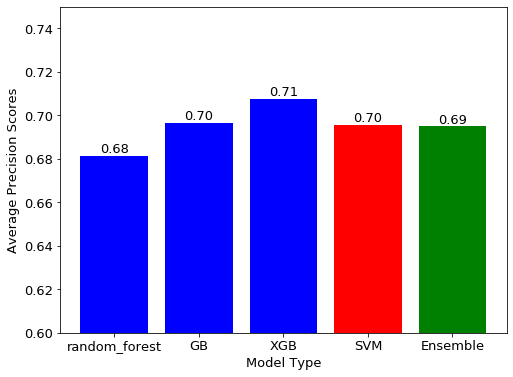

In [628]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(8,6))
labels = ['random_forest','GB','XGB','SVM','Ensemble']
colors = ['blue','blue','blue','red','green']
vals = list(eval_models.values())

for i in range(len(labels)):
    plt.bar(x=labels[i],height=list(eval_models.values())[i],color=colors[i])
for lab,val in zip(labels,vals):
    plt.text(lab, val, "%.2f" % round(val,2),
            ha='center', va='bottom')
plt.ylim((0.6,0.75))
plt.ylabel('Average Precision Scores')
plt.xlabel('Model Type')
plt.savefig('AvPrecision.png')
plt.show()

## Simulations

In [78]:
a = df2['ICD9_CODE_CAT'].unique().tolist()
a.remove('Complications Of Pregnancy, Childbirth, And The Puerperium')
a

['Other',
 'Injury And Poisoning',
 'Neoplasms',
 'Infectious And Parasitic Diseases',
 'Diseases Of The Digestive System',
 'Diseases Of The Circulatory System',
 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders',
 'Diseases Of The Respiratory System',
 'Diseases Of The Musculoskeletal System And Connective Tissue',
 'Diseases Of The Genitourinary System',
 'Diseases Of The Skin And Subcutaneous Tissue',
 'Mental Disorders',
 'Diseases Of The Nervous System And Sense Organs',
 'Congenital Anomalies',
 'Diseases Of The Blood And Blood-Forming Organs',
 'Symptoms, Signs, And Ill-Defined Conditions']

In [80]:
ages = []
for a in df2['age']:
    if a > 89:
        ages.append(90)
    else:
        ages.append(a)
        
ecdf = ECDF(ages)

age_cmf = {ecdf(a):a for a in range(np.max(ages)+1)}

In [81]:
def draw_age(age_cmf):
    draw_unif = np.random.uniform()
    
    key = -1
    for k in age_cmf.keys():
        if draw_unif > k:
            key = k
    draw = age_cmf[key]+1
    
    return(draw)

In [82]:
import collections

codes = df2[df2['age_group__40-64']==0][df2['age_group__65-89']==0][df2['age_group__>89']==0]['ICD9_CODE_CAT']
codes = [str(c) for c in codes]
ecdf_condition_40 = ECDF(codes)
condition_40_cmf = {ecdf_condition_40(a):a for a in codes}
od_40 = collections.OrderedDict(sorted(condition_40_cmf.items()))

codes = df2[df2['age_group__40-64']==1]['ICD9_CODE_CAT']
codes = [str(c) for c in codes]
ecdf_condition_40_64 = ECDF(codes)
condition_40_64_cmf = {ecdf_condition_40_64(a):a for a in codes}
od_40_64 = collections.OrderedDict(sorted(condition_40_64_cmf.items()))

codes = df2[df2['age_group__65-89']==1]['ICD9_CODE_CAT']
codes = [str(c) for c in codes]
ecdf_condition_65_89 = ECDF(codes)
condition_65_89_cmf = {ecdf_condition_65_89(a):a for a in codes}
od_65_89 = collections.OrderedDict(sorted(condition_65_89_cmf.items()))

codes = df2[df2['age_group__>89']==1]['ICD9_CODE_CAT']
codes = [str(c) for c in codes]
ecdf_condition_89 = ECDF(codes)
condition_89_cmf = {ecdf_condition_89(a):a for a in codes}
od_89 = collections.OrderedDict(sorted(condition_89_cmf.items()))

/Users/vivek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
def draw_condition_40():
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_40.keys()),list(od_40.values()),[draw_unif]*len(list(od_40.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

def draw_condition_40_64():
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_40_64.keys()),list(od_40_64.values()),[draw_unif]*len(list(od_40_64.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

def draw_condition_65_89():
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_65_89.keys()),list(od_65_89.values()),[draw_unif]*len(list(od_65_89.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

def draw_condition_89():
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_89.keys()),list(od_89.values()),[draw_unif]*len(list(od_89.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

In [84]:
def draw_agents1(n):
    age = []
    age_group = []
    condition = []
    gender_M = []

    for i in range(n):
        age.append(draw_age(age_cmf))
        if age[i] < 40:
            condition.append(draw_condition_40(od_40))
            age_group.append(1)
        elif age[i] <= 64: #& age[i] >= 40:
            condition.append(draw_condition_40_64(od_40_64))
            age_group.append(2)
        elif age[i] <= 89: #age[i] > 64 & age[i] <= 89:
            condition.append(draw_condition_65_89(od_65_89))
            age_group.append(3)
        else:
            condition.append(draw_condition_89(od_89))
            age_group.append(4)
        
        # Gender conditioned on some conditions
        if condition[i] == 'Complications Of Pregnancy, Childbirth, And The Puerperium':
            gender_M.append(0)
        elif condition[i] == 'Injury And Poisoning':
            counts = df2[df2['ICD9_CODE_CAT']=='Injury And Poisoning']['gender__M'].value_counts()
            gender_M.append(np.random.binomial(1,counts[1]/counts.sum()))
        elif condition[i] == 'Diseases Of The Circulatory System':
            counts = df2[df2['ICD9_CODE_CAT']=='Diseases Of The Circulatory System']['gender__M'].value_counts()
            gender_M.append(np.random.binomial(1,counts[1]/counts.sum()))
        elif condition[i] == 'Mental Disorders':
            counts = df2[df2['ICD9_CODE_CAT']=='Mental Disorders']['gender__M'].value_counts()
            gender_M.append(np.random.binomial(1,counts[1]/counts.sum()))
        else:
            gender_M.append(np.random.binomial(1,0.5))
    
    return(age,age_group,condition,gender_M)

In [85]:
df5 = df3[df3['days_since_admission']==0]

df5 = df5.drop(['days_since_admission','HOSPITAL_EXPIRE_FLAG','hospital_expire_flag',
               'ICUSTAY_ID', 'INTIME', 'OUTTIME', 'DIFF',
               'LAST_WARDID', 'GENDER','DOB', 'ICD9_CODE', 'SHORT_TITLE',
               'LONG_TITLE', 'SEQ_NUM', 'DEATHTIME','ICUSTAY_AGE_GROUP',
               'ICD9_CODE_CAT','date',
               'INTIME_ACTUAL', 'OUTTIME_ACTUAL',"CURR_CAREUNIT","INSURANCE","ADMISSION_TYPE","DATE","LOS"],axis=1) #
#'subject_id', 'hadm_id','SUBJECT_ID', 'HADM_ID', 

df5_index = df5.index

In [86]:
# Prepare variables for model
y_train=df5['out_flag']
X_train=df5.drop(['out_flag'],axis=1)

In [87]:
orig_index = X_train.index

In [88]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

imp_iter = IterativeImputer(random_state=0)
imp_iter.fit(X_train)
X_train = imp_iter.transform(X_train)

In [89]:
X_train = pd.DataFrame(X_train)
X_train.columns = df5.drop(['out_flag'],axis=1).columns

In [90]:
X_train.index = orig_index

In [92]:
X_train['age'] = [90 if a>89 else a for a in X_train['age']]

In [93]:
def sample_matches(X_train, knn_cols, draw_ac2):

    filt = X_train[knn_cols]
    sim = []
    sim2 = []
    sim2_df = pd.DataFrame(columns=X_train.columns)
    ages = []

    for j in range(draw_ac2.shape[0]):
        
        age = draw_ac2.loc[j,'age']
        selected = [i for i in filt[filt['gender__M']==draw_ac2.loc[j,'gender__M']].index] #Initialize with gender
        temp = []
        for col in knn_cols[1:]:
            temp = [i for i in filt[filt[col]==draw_ac2.loc[j,col]].index]
            new = list(set(selected) & set(temp))
            selected = np.copy(new)
        
            
        if len(selected) >= 10:
            sim.append(random.sample(list(selected),1)[0])
            ages.append(age)
        else:
            print('less than 10')
            sim2 = random.sample(list(selected),1)[0]
            sim2_df = pd.concat([sim2_df, X_train.loc[[sim2]]])
            mean_cols = ['gcs', 'heartrate', 
                'meanbp', 'resprate', 'temp', 'urineoutput','respiration','coagulation', 'liver',
               'cardiovascular', 'cns', 'renal', 'HeartRate_Min', 'HeartRate_Max',
               'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
               'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
               'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
               'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
               'Glucose_Min', 'Glucose_Max', 'Glucose_Mean']
            sim_mean = pd.DataFrame(X_train.loc[selected, mean_cols].mean()).transpose()
            for i in mean_cols:
                sim2_df.loc[sim2,i] = sim_mean[i][0]
            sim2_df.loc[sim2,'age'] = age

    sim1_df = X_train.loc[sim,]
    sim1_df['age'] = ages
    full_sim = pd.concat([sim2_df,sim1_df])
    return(full_sim,sim)

### Functions

In [94]:
from statsmodels.distributions.empirical_distribution import ECDF
import collections
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [95]:
def prep_age_cmf(df2):
    ages = []
    for a in df2['age']:
        if a > 89:
            ages.append(90)
        else:
            ages.append(a)

    ecdf = ECDF(ages)

    age_cmf = {ecdf(a):a for a in range(np.max(ages)+1)}
    return(age_cmf)

def draw_age(age_cmf):
    
    draw_unif = np.random.uniform()
    
    key = -1
    for k in age_cmf.keys():
        if draw_unif > k:
            key = k
    draw = age_cmf[key]+1
    
    return(draw)

In [96]:
def prep_ods (df2):
    codes = df2[df2['age_group__40-64']==0][df2['age_group__65-89']==0][df2['age_group__>89']==0]['ICD9_CODE_CAT']
    codes = [str(c) for c in codes]
    ecdf_condition_40 = ECDF(codes)
    condition_40_cmf = {ecdf_condition_40(a):a for a in codes}
    od_40 = collections.OrderedDict(sorted(condition_40_cmf.items()))

    codes = df2[df2['age_group__40-64']==1]['ICD9_CODE_CAT']
    codes = [str(c) for c in codes]
    ecdf_condition_40_64 = ECDF(codes)
    condition_40_64_cmf = {ecdf_condition_40_64(a):a for a in codes}
    od_40_64 = collections.OrderedDict(sorted(condition_40_64_cmf.items()))

    codes = df2[df2['age_group__65-89']==1]['ICD9_CODE_CAT']
    codes = [str(c) for c in codes]
    ecdf_condition_65_89 = ECDF(codes)
    condition_65_89_cmf = {ecdf_condition_65_89(a):a for a in codes}
    od_65_89 = collections.OrderedDict(sorted(condition_65_89_cmf.items()))

    codes = df2[df2['age_group__>89']==1]['ICD9_CODE_CAT']
    codes = [str(c) for c in codes]
    ecdf_condition_89 = ECDF(codes)
    condition_89_cmf = {ecdf_condition_89(a):a for a in codes}
    od_89 = collections.OrderedDict(sorted(condition_89_cmf.items()))
    
    return(od_40,od_40_64,od_65_89,od_89)

def draw_condition_40(od_40):
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_40.keys()),list(od_40.values()),[draw_unif]*len(list(od_40.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

def draw_condition_40_64(od_40_64):
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_40_64.keys()),list(od_40_64.values()),[draw_unif]*len(list(od_40_64.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

def draw_condition_65_89(od_65_89):
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_65_89.keys()),list(od_65_89.values()),[draw_unif]*len(list(od_65_89.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

def draw_condition_89(od_89):
    draw_unif = np.random.uniform()
    
    diffs = {c:a-b for a,c,b in zip(list(od_89.keys()),list(od_89.values()),[draw_unif]*len(list(od_89.keys()))) if (a-b)>0}
    draw = list(diffs.keys())[0]
    
    return(draw)

In [97]:
def draw_agents(n, df2, age_cmf,od_40,od_40_64,od_65_89,od_89):
    age = []
    age_group = []
    condition = []
    gender_M = []

    for i in range(n):
        age.append(draw_age(age_cmf))
        if age[i] < 40:
            condition.append(draw_condition_40(od_40))
            age_group.append(1)
        elif age[i] <= 64: 
            condition.append(draw_condition_40_64(od_40_64))
            age_group.append(2)
        elif age[i] <= 89:
            condition.append(draw_condition_65_89(od_65_89))
            age_group.append(3)
        else:
            condition.append(draw_condition_89(od_89))
            age_group.append(4)
        
        # Gender conditioned on some conditions
        if condition[i] == 'Complications Of Pregnancy, Childbirth, And The Puerperium':
            gender_M.append(0)
        elif condition[i] == 'Injury And Poisoning':
            counts = df2[df2['ICD9_CODE_CAT']=='Injury And Poisoning']['gender__M'].value_counts()
            gender_M.append(np.random.binomial(1,counts[1]/counts.sum()))
        elif condition[i] == 'Diseases Of The Circulatory System':
            counts = df2[df2['ICD9_CODE_CAT']=='Diseases Of The Circulatory System']['gender__M'].value_counts()
            gender_M.append(np.random.binomial(1,counts[1]/counts.sum()))
        elif condition[i] == 'Mental Disorders':
            counts = df2[df2['ICD9_CODE_CAT']=='Mental Disorders']['gender__M'].value_counts()
            gender_M.append(np.random.binomial(1,counts[1]/counts.sum()))
        else:
            gender_M.append(np.random.binomial(1,0.5))
    
    draw_acg = pd.DataFrame()
    draw_acg['age'] = age
    draw_acg['age_group'] = age_group
    draw_acg['ICD9_CODE_CAT'] = condition
    draw_acg['gender__M'] = gender_M
    
    age_groups = pd.get_dummies(draw_acg['age_group'],prefix='age_group_',drop_first=True)
    age_groups = age_groups.rename(columns={"age_group__2": "age_group__40-64", "age_group__3": "age_group__65-89", "age_group__4": "age_group__>89"})
    draw_acg = pd.concat([draw_acg,age_groups],axis=1)
    
    return(draw_acg)

In [98]:
def prep_train (df3):
    df5 = df3[df3['days_since_admission']==0]

    df5 = df5.drop(['days_since_admission','HOSPITAL_EXPIRE_FLAG','hospital_expire_flag',
                   'ICUSTAY_ID', 'INTIME', 'OUTTIME', 'DIFF',
                   'LAST_WARDID', 'GENDER','DOB', 'ICD9_CODE', 'SHORT_TITLE',
                   'LONG_TITLE', 'SEQ_NUM', 'DEATHTIME','ICUSTAY_AGE_GROUP',
                   'ICD9_CODE_CAT','date',
                   'INTIME_ACTUAL', 'OUTTIME_ACTUAL',"CURR_CAREUNIT","INSURANCE","ADMISSION_TYPE","DATE","LOS",
#                    'COUNT_DOCTORS', 'COUNT_NURSES', 'COUNT_PATIENTS',
                   'cum_caretime_doctors','cum_caretime_nurses'],axis=1)
    #'subject_id', 'hadm_id','SUBJECT_ID', 'HADM_ID', 

    y_train=df5['out_flag']
    X_train=df5.drop(['out_flag'],axis=1)

    imp_iter = IterativeImputer(random_state=0)
    imp_iter.fit(X_train)
    X_train = imp_iter.transform(X_train)

    X_train = pd.DataFrame(X_train)
    X_train.columns = df5.drop(['out_flag'],axis=1).columns

    X_train['age'] = [90 if a>89 else a for a in X_train['age']]
        
    return(X_train, y_train)

In [99]:
def encode_age (df, index, new_age):
    df.loc[index,"age_group__>89"] = 0
    df.loc[index,"age_group__65-89"] = 0
    df.loc[index,"age_group__40-64"] = 0

    if new_age > 89:
        df.loc[index,"age_group__>89"] = 1
    elif new_age >= 65:
        df.loc[index,"age_group__65-89"] = 1
    elif new_age >= 40:
        df.loc[index,"age_group__40-64"] = 1

In [100]:
def sample_matches(X_train, knn_cols, draw_acg2):

    filt = X_train[knn_cols]
    sim = []
    sim2 = []
    sim2_df = pd.DataFrame(columns=X_train.columns)
    ages = []

    for j in range(draw_acg2.shape[0]):
        
        age = draw_acg2.loc[j,'age']
        selected = [i for i in filt[filt['gender__M']==draw_acg2.loc[j,'gender__M']].index] #Initialize with gender
        temp = []
        for col in knn_cols[1:]:
            temp = [i for i in filt[filt[col]==draw_acg2.loc[j,col]].index]
            new = list(set(selected) & set(temp))
            selected = np.copy(new)
        
        if len(selected) >= 10:
            sim.append(random.sample(list(selected),1)[0])
            ages.append(age)
        elif len(selected) == 0:
            print('no match')
        else:
            print('less than 10')
            sim2 = random.sample(list(selected),1)[0]
            sim2_df = pd.concat([sim2_df, X_train.loc[[sim2]]])
            mean_cols = ['gcs', 'heartrate', 
                'meanbp', 'resprate', 'temp', 'urineoutput','respiration','coagulation', 'liver',
               'cardiovascular', 'cns', 'renal', 'HeartRate_Min', 'HeartRate_Max',
               'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
               'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
               'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
               'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
               'Glucose_Min', 'Glucose_Max', 'Glucose_Mean']
            
            sim_mean = pd.DataFrame(X_train.loc[selected, mean_cols].mean()).transpose()
            
            age_up = age + 25
            encode_age (draw_acg2, j, age_up)
    
            selected_up = [i for i in filt[filt['gender__M']==draw_acg2.loc[j,'gender__M']].index] #Initialize with gender
            temp = []
            for col in knn_cols[1:]:
                temp = [i for i in filt[filt[col]==draw_acg2.loc[j,col]].index]
                new = list(set(selected_up) & set(temp))
                selected_up = np.copy(new)

            age_down = age - 25
            encode_age (draw_acg2, j, age_down)
            
            selected_down = [i for i in filt[filt['gender__M']==draw_acg2.loc[j,'gender__M']].index] #Initialize with gender
            temp = []
            for col in knn_cols[1:]:
                temp = [i for i in filt[filt[col]==draw_acg2.loc[j,col]].index]
                new = list(set(selected_down) & set(temp))
                selected_down = np.copy(new)
            
            selected = selected.tolist()
            selected.extend(selected_up)
            selected.extend(selected_down)
            
            selected_exp = list(set(selected))

            sim_sd = pd.DataFrame(X_train.loc[selected_exp, mean_cols].std()).transpose()
                        
            for i in mean_cols:
                sim2_df.loc[sim2,i] = np.random.normal(sim_mean[i][0], sim_sd[i][0])
            sim2_df.loc[sim2,'age'] = age

    sim1_df = X_train.loc[sim,]
    sim1_df['age'] = ages
    full_sim = pd.concat([sim2_df,sim1_df])
    return(full_sim)

In [101]:
def hundred_sim(df6,df3,col_ord,full_sim):
    df6 = df6.loc[:,['ICUSTAY_ID']+col_ord]
    pat_rec = df6[df6['ICUSTAY_ID']==df3.loc[full_sim.index[0],:]['ICUSTAY_ID']]
    daily = pat_rec[['days_since_admission','procedure_SignificantEvents','procedure_Ventilation']]
    included = set([d for d in daily['days_since_admission']])
    for i in range(1010):
        if i not in included:
            day = pd.DataFrame({'days_since_admission':[i],'procedure_SignificantEvents':[0],'procedure_Ventilation':[0]})
            daily = pd.concat([daily,day],axis=0)
    daily = daily.reset_index()
    daily = daily.drop('index',axis=1)
    newdf = pd.DataFrame(np.repeat(full_sim.values,110,axis=0))
    newdf.columns = full_sim.columns
    newdf = newdf.drop('days_since_admission',axis=1)
    return(pd.concat([newdf,daily],axis=1))
    

In [102]:
def simulate (n, df2, df3, df6, X_train, age_cmf, od_40,od_40_64,od_65_89,od_89, diagnosis_encoder, col_ord):

    draw_acg = draw_agents(n, df2, age_cmf, od_40, od_40_64, od_65_89, od_89)
    
    ICD9_CODE_CAT_binary = diagnosis_encoder.transform(draw_acg['ICD9_CODE_CAT'])
    draw_acg2 = pd.concat([draw_acg,ICD9_CODE_CAT_binary],axis=1).drop(['ICD9_CODE_CAT','age','age_group'],axis=1)
    draw_acg2 = pd.concat([draw_acg['age'],draw_acg2],axis=1)
    knn_cols = [c for c in draw_acg2.columns]
    
    full_sim = sample_matches(X_train, knn_cols, draw_acg2)
    
#     full_sim = full_sim.reset_index()
#     full_sim = full_sim.drop('index',axis=1)
    full_sim['days_since_admission'] = 0
    
    col_order = [f for f in col_ord if f not in ['procedure_SignificantEvents','procedure_Ventilation','cum_caretime_doctors','cum_caretime_nurses']]
    full_sim = full_sim[col_order]
    
    out = hundred_sim(df6,df3,col_ord,full_sim)
    
    return(out)

In [103]:
age_cmf = prep_age_cmf(df2)
od_40,od_40_64,od_65_89,od_89 = prep_ods(df2)
X_train, y_train = prep_train(df3)

/Users/vivek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


# ABM MESA

## Key functions for ABM

In [104]:
intimes = df2["INTIME_ACTUAL"].astype("datetime64")
intimes_count= intimes.groupby(intimes.dt.date).count()

ecdf2 = ECDF(intimes_count)
patient_inflow_cmf = {ecdf2(a):a for a in range(np.max(intimes_count)+1)}

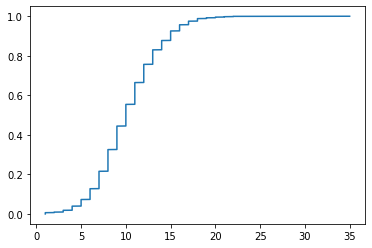

In [105]:
# plot the cdf
plt.plot(ecdf2.x, ecdf2.y)
plt.show()

In [106]:
def draw_patient_inflow():
    draw_unif = np.random.uniform()
    
    key = -1
    for k in patient_inflow_cmf.keys():
        if draw_unif > k:
            key = k
    draw = patient_inflow_cmf[key]+1
    
    return(draw)

In [107]:
def get_location(x):
    if x['careunit__CSRU'] == 1: return 'CSRU'
    elif x['careunit__MICU'] == 1: return 'MICU'
    elif x['careunit__SICU'] == 1: return 'SICU'
    elif x['careunit__TSICU'] == 1: return 'TSICU'
    else: return "Other"

In [ ]:
def write_to_csv(run_data,name_suffix):
    df_model_vars = pd.DataFrame()
    df_agent_vars = pd.DataFrame()

    for i in range(run_data.shape[0]):
        run_model_vars = run_data.loc[i,'all'].get_model_vars_dataframe()
        run_model_vars['run_number'] = i
        run_model_vars['n_nurses'] = run_data.loc[i,'n_nurses']
        run_model_vars['n_doctors'] = run_data.loc[i,'n_doctors']
        run_model_vars['max_agents'] = run_data.loc[i,'max_agents']
        run_model_vars['n_agents'] = run_data.loc[i,'n_agents']
        df_model_vars = pd.concat([df_model_vars,run_model_vars],axis=0)
        
        run_agent_vars = pd.DataFrame(run_data.loc[i,'all'].get_agent_vars_dataframe().to_records())
        run_agent_vars['run_number'] = i
        df_agent_vars = pd.concat([df_agent_vars,run_agent_vars],axis=0)
    
    model_file_name = 'output/model_output_' + str(name_suffix) + '.csv'
    agent_file_name = 'output/agent_output_' + str(name_suffix) + '.csv'
    df_model_vars.to_csv(model_file_name)
    df_agent_vars.to_csv(agent_file_name)
    print(model_file_name + ' done')
    print(agent_file_name + ' done')

## Model Runs for SVM

In [153]:
class MyActivation(BaseScheduler):

    def step(self): # -> None
        """ Executes the step of all agents, one at a time, in
        random order.

        """
        for agent in self.agent_buffer(shuffled=True):
            agent.step()
        self.steps += 1
        self.time += 1
        
    def advance(self) :#-> None
        for agent in self.agent_buffer(shuffled=True):
            agent.advance()

In [154]:
class PatienFlowModel(Model):
    def __init__(self, n_agents=20, max_agents=50, n_doctors=3, n_nurses=250,service_level=1): #agent_LOS,
        super().__init__()
        
        self.n_agents = n_agents
        self.max_agents = max_agents
        self.n_doctors = n_doctors
        self.n_nurses = n_nurses
        self.max_cap_by = 0
        self.max_cap_daily = 0
        self.service_level = service_level
        self.caretime_doctors = 0
        self.caretime_nurses = 0
        self.count_discharges = 0
        self.count_deaths = 0
        self.demand_serviced = 0
                
        # keep track of the the remaining life of an agent and
        # how many ticks it has seen
        self.datacollector = DataCollector(model_reporters={"agent_count":lambda m: m.schedule.get_agent_count(),
                                                           "max_cap_by":lambda m: m.max_cap_by,
                                                           "max_cap_daily":lambda m: m.max_cap_daily,
                                                           "count_discharges":lambda m: m.count_discharges,
                                                           "count_deaths":lambda m: m.count_deaths,
                                                           "demand_serviced":lambda m: m.demand_serviced},
            agent_reporters={"out_flag": lambda a: a.out_flag,
                             "days_in_hospital": lambda a: a.steps, # +1 Because if prediction of out_flag is 0 or -1, then LOS is 1 not 0
                            "info": lambda a: a.info,
                            "NPI": lambda a: a.NPI,
                            "Careunit": lambda a: a.careunit,
                            "cum_caretime_doctors": lambda a: a.caretime_doctors,
                            "cum_caretime_nurses": lambda a: a.caretime_nurses}) 

        self.current_ID = 0
        self.schedule = MyActivation(self)

        for _ in range(self.n_agents):
            prior_steps = np.random.randint(low=1,high=4,size=1)[0] 
            self.schedule.add(PatienFlowAgent(self.next_id(),self,prior_steps))

    def step(self):
        
        # Here we define how many new agents/patients are drawn from ECDF(based on empirical distribution from real data)
        new_patients = draw_patient_inflow()

        if len(self.schedule.agents) + new_patients <= round(self.service_level * self.max_agents):
            for _ in range(new_patients):
                self.schedule.add(PatienFlowAgent(self.next_id(),self))
            self.max_cap_daily = 0
        elif len(self.schedule.agents) < round(self.service_level * self.max_agents):
            new_patients_2 = round(self.service_level * self.max_agents) - len(self.schedule.agents)
            for _ in range(new_patients_2):
                self.schedule.add(PatienFlowAgent(self.next_id(),self))    
            self.max_cap_daily = new_patients - new_patients_2
            self.max_cap_by += self.max_cap_daily
        else:
            self.max_cap_daily = new_patients
            self.max_cap_by += self.max_cap_daily
            
        self.caretime_doctors = self.n_doctors/len(self.schedule.agents)
        self.caretime_nurses = self.n_nurses/len(self.schedule.agents)
        
        self.schedule.step()
        self.datacollector.collect(self)
        self.schedule.advance()

        self.demand_serviced = 1-self.max_cap_by/(len(self.schedule.agents)+self.max_cap_by+self.count_discharges+self.count_deaths)

    def run_model(self, step_count=100):
        for _ in range(step_count):
            self.step()


class PatienFlowAgent(Agent):

    def __init__(self, unique_id, model, prior_steps=0): #LOS, 
        super().__init__(unique_id, model)
        self.steps = prior_steps
        self.model = model
         # Simulation of new agents
        self.info = simulate(1, df2, df3, df6, X_train, age_cmf, od_40,od_40_64,od_65_89,od_89, diagnosis_encoder, col_ord)
        self.info['cum_caretime_doctors'] = 0
        self.info['cum_caretime_nurses'] = 0
        self.caretime_doctors = 0
        self.caretime_nurses = 0
        self.NPI = 3
        self.careunit = self.info.apply(get_location, axis=1)[0]
        self.out_flag = 0
        
    def step(self):
            curr_info = self.info.loc[[self.steps]]
            self.caretime_doctors += self.model.caretime_doctors
            self.caretime_nurses  += self.model.caretime_nurses
            curr_info['cum_caretime_doctors'] += self.caretime_doctors
            curr_info['cum_caretime_nurses'] += self.caretime_nurses
            self.NPI = self.model.n_nurses / len(self.model.schedule.agents)
            self.careunit = self.info.apply(get_location, axis=1)[0]
            self.out_flag = prediction_svm(curr_info,False)[0]
            
            # This part is to correct for very short-term releases that occur too often:
            if self.out_flag != 0 and self.steps < 4:
                draw = np.random.binomial(1,0.5)
                if draw==0:
                    self.out_flag = 0
            
            self.steps += 1  # keep track of how many ticks are seen
                
    def advance(self):
        #if  self.out_flag == 1 or self.out_flag == 2: #  When the patient is discharged/passes away, remove from model
            #self.model.schedule.remove(self)
        if self.out_flag == 2:
            self.model.count_discharges +=1
            self.model.schedule.remove(self)
        if self.out_flag == 1:
            self.model.count_deaths +=1
            self.model.schedule.remove(self)


In [159]:

fixed_params = {
   "n_agents": 50,
    "max_agents": 80
}
parameters = {"n_doctors": [1,3,5], "n_nurses": [200,300,400]}
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        fixed_params,
                        iterations=1,
                        max_steps=100,
                        model_reporters={"all":lambda m: m.datacollector})
batch_run.run_all()

run_data = batch_run.get_model_vars_dataframe()
write_to_csv(run_data,11)
del batch_run
del run_data

In [ ]:

fixed_params = {
   "n_agents": 50,
    "max_agents": 80
}
parameters = {"n_doctors": [1,3,5], "n_nurses": [200,300,400]}
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        fixed_params,
                        iterations=1,
                        max_steps=100,
                        model_reporters={"all":lambda m: m.datacollector})
batch_run.run_all()

run_data = batch_run.get_model_vars_dataframe()
write_to_csv(run_data,12)
del batch_run
del run_data

In [ ]:

fixed_params = {
   "n_agents": 50,
    "max_agents": 80
}
parameters = {"n_doctors": [1,3,5], "n_nurses": [200,300,400]}
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        fixed_params,
                        iterations=1,
                        max_steps=100,
                        model_reporters={"all":lambda m: m.datacollector})
batch_run.run_all()

run_data = batch_run.get_model_vars_dataframe()
write_to_csv(run_data,13)
del batch_run
del run_data

In [ ]:

fixed_params = {
   "n_agents": 50,
    "max_agents": 100
}
parameters = {"n_doctors": [1,3,5], "n_nurses": [200,300,400]}
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        fixed_params,
                        iterations=1,
                        max_steps=100,
                        model_reporters={"all":lambda m: m.datacollector})
batch_run.run_all()

run_data2 = batch_run.get_model_vars_dataframe()
write_to_csv(run_data2,21)
del batch_run
del run_data2

In [ ]:

fixed_params = {
   "n_agents": 50,
    "max_agents": 100
}
parameters = {"n_doctors": [1,3,5], "n_nurses": [200,300,400]}
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        fixed_params,
                        iterations=1,
                        max_steps=100,
                        model_reporters={"all":lambda m: m.datacollector})
batch_run.run_all()

run_data2 = batch_run.get_model_vars_dataframe()
write_to_csv(run_data2,22)
del batch_run
del run_data2

In [ ]:

fixed_params = {
   "n_agents": 50,
    "max_agents": 100
}
parameters = {"n_doctors": [1,3,5], "n_nurses": [200,300,400]}
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        fixed_params,
                        iterations=1,
                        max_steps=100,
                        model_reporters={"all":lambda m: m.datacollector})
batch_run.run_all()

run_data2 = batch_run.get_model_vars_dataframe()
write_to_csv(run_data2,23)
del batch_run
del run_data2

In [ ]:

fixed_params = {
   "n_agents": 50,
    "max_agents": 120
}
parameters = {"n_doctors": [1,3,5], "n_nurses": [200,300,400]}
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        fixed_params,
                        iterations=1,
                        max_steps=100,
                        model_reporters={"all":lambda m: m.datacollector})
batch_run.run_all()

run_data3 = batch_run.get_model_vars_dataframe()
write_to_csv(run_data3,31)
del batch_run
del run_data3

In [ ]:

fixed_params = {
   "n_agents": 50,
    "max_agents": 120
}
parameters = {"n_doctors": [1,3,5], "n_nurses": [200,300,400]}
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        fixed_params,
                        iterations=1,
                        max_steps=100,
                        model_reporters={"all":lambda m: m.datacollector})
batch_run.run_all()

run_data3 = batch_run.get_model_vars_dataframe()
write_to_csv(run_data3,32)
del batch_run
del run_data3

In [ ]:

fixed_params = {
   "n_agents": 50,
    "max_agents": 120
}
parameters = {"n_doctors": [1,3,5], "n_nurses": [200,300,400]}
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        fixed_params,
                        iterations=1,
                        max_steps=100,
                        model_reporters={"all":lambda m: m.datacollector})
batch_run.run_all()

run_data3 = batch_run.get_model_vars_dataframe()
write_to_csv(run_data3,33)
del batch_run
del run_data3

## Model Runs for XGB

In [108]:
class MyActivation(BaseScheduler):

    def step(self): # -> None

        for agent in self.agent_buffer(shuffled=True):
            agent.step()
        self.steps += 1
        self.time += 1
        
    def advance(self) :#-> None
        for agent in self.agent_buffer(shuffled=True):
            agent.advance()

In [109]:
class PatienFlowModel(Model):
    def __init__(self, n_agents=50, max_agents=80, n_doctors=3, n_nurses=250,service_level=1): #agent_LOS,
        super().__init__()
        
        self.n_agents = n_agents
        self.max_agents = max_agents
        self.n_doctors = n_doctors
        self.n_nurses = n_nurses
        self.max_cap_by = 0
        self.max_cap_daily = 0
        self.service_level = service_level
        self.caretime_doctors = 0
        self.caretime_nurses = 0
        self.count_discharges = 0
        self.count_deaths = 0
        self.demand_serviced = 0
                
        # keep track of the the remaining life of an agent and
        # how many ticks it has seen
        self.datacollector = DataCollector(model_reporters={"agent_count":lambda m: m.schedule.get_agent_count(),
                                                           "max_cap_by":lambda m: m.max_cap_by,
                                                           "max_cap_daily":lambda m: m.max_cap_daily,
                                                           "count_discharges":lambda m: m.count_discharges,
                                                           "count_deaths":lambda m: m.count_deaths,
                                                           "demand_serviced":lambda m: m.demand_serviced},
            agent_reporters={"out_flag": lambda a: a.out_flag,
                             "days_in_hospital": lambda a: a.steps, # +1 Because if prediction of out_flag is 0 or -1, then LOS is 1 not 0
                            "info": lambda a: a.info,
                            "NPI": lambda a: a.NPI,
                            "Careunit": lambda a: a.careunit,
                            "cum_caretime_doctors": lambda a: a.caretime_doctors,
                            "cum_caretime_nurses": lambda a: a.caretime_nurses}) 

        self.current_ID = 0
        self.schedule = MyActivation(self)

        for _ in range(self.n_agents):
            # Set seed here
            prior_steps = np.random.randint(low=1,high=4,size=1)[0] #Should be a random draw
            self.schedule.add(PatienFlowAgent(self.next_id(),self,prior_steps))

    def step(self):
        
        # Here we define how many new agents/patients are drawn from ECDF(based on empirical distribution from real data)
        new_patients = draw_patient_inflow()

        if len(self.schedule.agents) + new_patients <= round(self.service_level * self.max_agents):
            for _ in range(new_patients):
                self.schedule.add(PatienFlowAgent(self.next_id(),self))
            self.max_cap_daily = 0
        elif len(self.schedule.agents) < round(self.service_level * self.max_agents):
            new_patients_2 = round(self.service_level * self.max_agents) - len(self.schedule.agents)
            for _ in range(new_patients_2):
                self.schedule.add(PatienFlowAgent(self.next_id(),self))    
            self.max_cap_daily = new_patients - new_patients_2
            self.max_cap_by += self.max_cap_daily
        else:
            self.max_cap_daily = new_patients
            self.max_cap_by += self.max_cap_daily
            
        self.caretime_doctors = self.n_doctors/len(self.schedule.agents)
        self.caretime_nurses = self.n_nurses/len(self.schedule.agents)
        
        self.schedule.step()
        self.datacollector.collect(self)
        self.schedule.advance()

        self.demand_serviced = 1-self.max_cap_by/(len(self.schedule.agents)+self.max_cap_by+self.count_discharges+self.count_deaths)

    def run_model(self, step_count=100):
        for _ in range(step_count):
            self.step()


class PatienFlowAgent(Agent):

    def __init__(self, unique_id, model, prior_steps=0): #LOS, 
        super().__init__(unique_id, model)
        self.steps = prior_steps
        self.model = model
         # Simulation of new agents
        self.info = simulate(1, df2, df3, df6, X_train, age_cmf, od_40,od_40_64,od_65_89,od_89, diagnosis_encoder, col_ord)
        self.info['cum_caretime_doctors'] = 0
        self.info['cum_caretime_nurses'] = 0
        self.caretime_doctors = 0
        self.caretime_nurses = 0
        self.NPI = 3
        self.careunit = self.info.apply(get_location, axis=1)[0]
        self.out_flag = 0
        
    def step(self):
            curr_info = self.info.loc[[self.steps]]
            self.caretime_doctors += self.model.caretime_doctors
            self.caretime_nurses  += self.model.caretime_nurses
            curr_info['cum_caretime_doctors'] += self.caretime_doctors
            curr_info['cum_caretime_nurses'] += self.caretime_nurses

            self.NPI = self.model.n_nurses / len(self.model.schedule.agents)
            self.careunit = self.info.apply(get_location, axis=1)[0]
            self.out_flag = prediction_xgb(curr_info,False)[0] #forest.predict(self.info)[0]
            # This part is to correct for very short-term releases that occur too often:
            if self.out_flag != 0 and self.steps < 4:
                draw = np.random.binomial(1,0.5)
                if draw==0:
                    self.out_flag = 0
            
            self.steps += 1  # keep track of how many ticks are seen
            
                
    def advance(self):
        if self.out_flag == 2:
            self.model.count_discharges +=1
            self.model.schedule.remove(self)
        if self.out_flag == 1:
            self.model.count_deaths +=1
            self.model.schedule.remove(self)


In [ ]:

fixed_params = {
   "n_agents": 50,
    "max_agents": 80
}
parameters = {"n_doctors": [1,3,5], "n_nurses": [200,300,400]} 
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        fixed_params,
                        iterations=3, 
                        max_steps=100, 
                        model_reporters={"all":lambda m: m.datacollector})
batch_run.run_all()

run_data = batch_run.get_model_vars_dataframe()
write_to_csv(run_data,1)

In [ ]:

fixed_params = {
   "n_agents": 50,
    "max_agents": 100
}
parameters = {"n_doctors": [1,3,5], "n_nurses": [200,300,400]}
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        fixed_params,
                        iterations=3,
                        max_steps=100,
                        model_reporters={"all":lambda m: m.datacollector})
batch_run.run_all()

run_data2 = batch_run.get_model_vars_dataframe()
write_to_csv(run_data2,2)

In [ ]:

fixed_params = {
   "n_agents": 50,
    "max_agents": 120
}
parameters = {"n_doctors": [1,3,5], "n_nurses": [200,300,400]}
batch_run = BatchRunner(PatienFlowModel, 
                        parameters,
                        fixed_params,
                        iterations=3,
                        max_steps=100,
                        model_reporters={"all":lambda m: m.datacollector})
batch_run.run_all()

run_data3 = batch_run.get_model_vars_dataframe()
write_to_csv(run_data3,3)

# Analysis of ABM Runs

In [ ]:
# Information from MIMIC Data

caretime_info = pd.DataFrame(df3[['ICUSTAY_ID','cum_caretime_doctors','cum_caretime_nurses']]
                             .groupby('ICUSTAY_ID').max().to_records())

LOS_info = df3[['ICUSTAY_ID','LOS']].groupby('ICUSTAY_ID').max()['LOS']

mortality_LOS_info = pd.DataFrame(df3[['ICUSTAY_ID','HOSPITAL_EXPIRE_FLAG','LOS']]
                             .groupby('ICUSTAY_ID').max().to_records())

# Getting LOS only of those cases where patients passes away
mortality_LOS_info2 = mortality_LOS_info[mortality_LOS_info['HOSPITAL_EXPIRE_FLAG']==1]

fatal_df=df6[df6["HOSPITAL_EXPIRE_FLAG"]==1] # Fatalities

## For SVM submodel

In [511]:
model_11 = pd.read_csv('output_svm2/model_output_11.csv')
agent_11 = pd.read_csv('output_svm2/agent_output_11.csv')
model_12 = pd.read_csv('output_svm2/model_output_12.csv')
agent_12 = pd.read_csv('output_svm2/agent_output_12.csv')
model_13 = pd.read_csv('output_svm2/model_output_13.csv')
agent_13 = pd.read_csv('output_svm2/agent_output_13.csv')
model_21 = pd.read_csv('output_svm2/model_output_21.csv')
agent_21 = pd.read_csv('output_svm2/agent_output_21.csv')
model_22 = pd.read_csv('output_svm2/model_output_22.csv')
agent_22 = pd.read_csv('output_svm2/agent_output_22.csv')
model_23 = pd.read_csv('output_svm2/model_output_23.csv')
agent_23 = pd.read_csv('output_svm2/agent_output_23.csv')
model_31 = pd.read_csv('output_svm2/model_output_31.csv')
agent_31 = pd.read_csv('output_svm2/agent_output_31.csv')
model_32 = pd.read_csv('output_svm2/model_output_32.csv')
agent_32 = pd.read_csv('output_svm2/agent_output_32.csv')
model_33 = pd.read_csv('output_svm2/model_output_33.csv')
agent_33 = pd.read_csv('output_svm2/agent_output_33.csv')


In [512]:
model_12['run_number'] = model_12['run_number']+9
agent_12['run_number'] = agent_12['run_number']+9
model_13['run_number'] = model_13['run_number']+9*2
agent_13['run_number'] = agent_13['run_number']+9*2
model_21['run_number'] = model_21['run_number']+9*3
agent_21['run_number'] = agent_21['run_number']+9*3
model_22['run_number'] = model_22['run_number']+9*4
agent_22['run_number'] = agent_22['run_number']+9*4
model_23['run_number'] = model_23['run_number']+9*5
agent_23['run_number'] = agent_23['run_number']+9*5
model_31['run_number'] = model_31['run_number']+9*6
agent_31['run_number'] = agent_31['run_number']+9*6
model_32['run_number'] = model_32['run_number']+9*7
agent_32['run_number'] = agent_32['run_number']+9*7
model_33['run_number'] = model_33['run_number']+9*8
agent_33['run_number'] = agent_33['run_number']+9*8

In [513]:
df_model_vars = pd.concat([model_11,model_12,model_13,model_21,model_22,model_23,model_31,model_32,model_33],axis=0)
df_agent_vars = pd.concat([agent_11,agent_12,agent_13,agent_21,agent_22,agent_23,agent_31,agent_32,agent_33],axis=0)


In [755]:
data = df_agent_vars[df_agent_vars['run_number']==18]#.get_agent_vars_dataframe()
data_model = df_model_vars[df_model_vars['run_number']==18]
cap = data_model['max_agents'].max()
flat_info = pd.DataFrame(data.to_records())
# flat_info[flat_info['Step']==10]['Careunit'].value_counts()

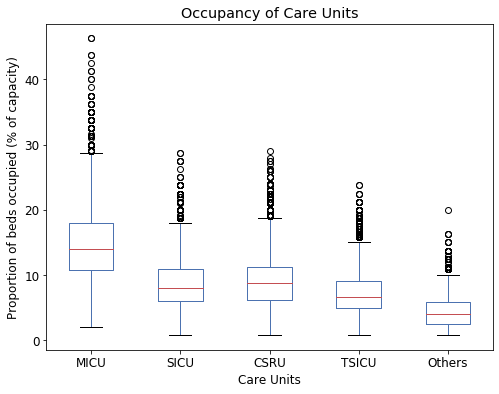

In [768]:
unit_count1 =[]
for i in range(df_agent_vars['run_number'].max()):
    #data = run_data.loc[i,'all'].get_agent_vars_dataframe()
    data = df_agent_vars[df_agent_vars['run_number']==i]#.get_agent_vars_dataframe()
    data_model = df_model_vars[df_model_vars['run_number']==i]
    cap = data_model['max_agents'].max()
    flat_info = pd.DataFrame(data.to_records())
    
    for i in flat_info['Step'].unique():
        unit_count1.append((flat_info[flat_info['Step']==i]['Careunit'].value_counts()/cap*100).to_dict())

unit_count1 = pd.DataFrame(unit_count1)
    #all_values.append(max(unit_count['MICU']))
    #plt.plot(unit_count1['MICU'],color='grey',alpha=0.1)

unit_count_all= unit_count1
unit_count_all['Others']=unit_count_all['Other']
unit_count_all=unit_count_all.drop(columns='Other')

plt.figure(figsize=(8,6))
unit_count_all.boxplot(grid=False)
plt.ylabel("Proportion of beds occupied (% of capacity)")
plt.title("Occupancy of Care Units")
plt.xlabel('Care Units')
plt.savefig('careunit_countpatients2.png')
plt.show()

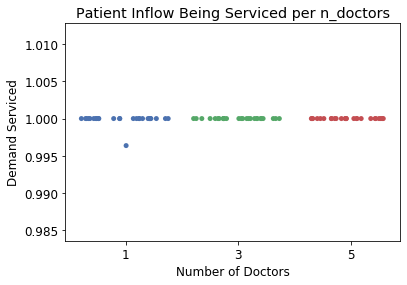

In [709]:
#plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 12})
# data2 = model_output_1[0::101] # 100 iterations per param setting
# data3 = model_output_2[0::101]
# data4 = model_output_3[0::101]
demand_serviced =[]
n_docs =[]
for i in range(df_model_vars['run_number'].max()):
    #data = run_data.loc[i,'all'].get_model_vars_dataframe()
    data = df_model_vars[df_model_vars['run_number']==i]
#     param1 = data['n_nurses'].iloc[i]#data2['n_nurses'].iloc[i]
    param2 = data[['n_doctors','n_nurses']].iloc[0].min()#data2['n_doctors'].iloc[i]
    param3 = data['max_agents'].iloc[0]#data2['max_agents'].iloc[i]
    n_docs.append(param2)
    flat_info = pd.DataFrame(data.to_records())
    overall_demand_serviced = flat_info['demand_serviced'].iloc[-1] # take the last value as that represent the aggregated demand serviced
    demand_serviced.append(overall_demand_serviced)

sns.stripplot(n_docs,demand_serviced, jitter=0.4)

plt.title('Patient Inflow Being Serviced per n_doctors')
plt.xlabel('Number of Doctors')
plt.ylabel('Demand Serviced')
plt.locator_params(axis='x', nbins=len(np.unique(n_docs)))
#plt.xlim(20,80)
#plt.ylim(0.80,1.01)
#plt.legend()
plt.savefig('demand_serviced4.png')
plt.show()

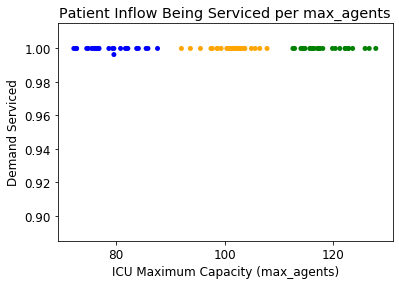

In [717]:
cols = {80:'blue',100:'orange',120:'green'}
#plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 12})
# data2 = model_output_1[0::100] # 100 iterations per param setting
# data3 = model_output_2[0::100]
# data4 = model_output_3[0::100]
demand_serviced =[]
max_agents =[]
for i in range(df_model_vars['run_number'].max()):
    #data = run_data.loc[i,'all'].get_model_vars_dataframe()
    data = df_model_vars[df_model_vars['run_number']==i]
    param1 = data[['n_doctors','n_nurses']].iloc[0].max()
    param2 = data[['n_doctors','n_nurses']].iloc[0].min()
    param3 = data['max_agents'].iloc[0]

    max_agents.append(param3)
    flat_info = pd.DataFrame(data.to_records())
    overall_demand_serviced = flat_info['demand_serviced'].iloc[-1] # take the last value as that represent the aggregated demand serviced
    demand_serviced.append(overall_demand_serviced)
#     if param2 == 1:
        #plt.scatter(max_agents,demand_serviced,color='red',alpha=0.01,marker='o',label='n_doctors {}'.format(param2))

color_plot = [cols[m] for m in max_agents]
sns.stripplot(max_agents,demand_serviced, jitter=0.4,palette=['blue','orange','green'])

plt.title('Patient Inflow Being Serviced per max_agents')
plt.xlabel('ICU Maximum Capacity (max_agents)')
plt.ylabel('Demand Serviced')
plt.locator_params(axis='x', nbins=len(np.unique(max_agents)))
#plt.xlim(20,80)
plt.ylim(0.885,1.015)
#plt.legend()
plt.savefig('demand_serviced2.png')
plt.show()

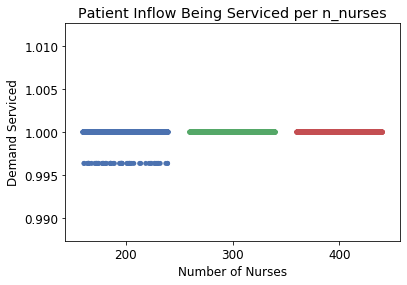

In [687]:
#plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 12})

demand_serviced =[]
n_nurses =[]
for i in range(df_model_vars['run_number'].max()):
    #data = run_data.loc[i,'all'].get_model_vars_dataframe()
    data = df_model_vars[df_model_vars['run_number']==i]
    param1 = data[['n_doctors','n_nurses']].iloc[0].max()
    param2 = data[['n_doctors','n_nurses']].iloc[0].min()
    param3 = data['max_agents'].iloc[0]
    n_nurses.append(param1)
    flat_info = pd.DataFrame(data.to_records())
    overall_demand_serviced = flat_info['demand_serviced'].iloc[-1] # take the last value as that represent the aggregated demand serviced
    demand_serviced.append(overall_demand_serviced)
    sns.stripplot(n_nurses,demand_serviced, jitter=0.4)


plt.title('Patient Inflow Being Serviced per n_nurses')
plt.xlabel('Number of Nurses')
plt.ylabel('Demand Serviced')
plt.locator_params(axis='x', nbins=len(np.unique(n_nurses)))
#plt.xlim(20,80)
#plt.ylim(0.80,1.01)
#plt.legend()
plt.savefig('demand_serviced3.png')
plt.show()

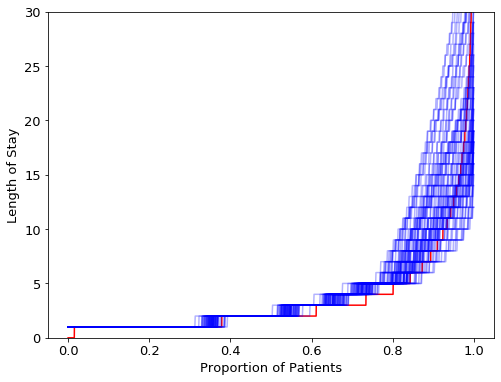

In [515]:
plt.figure(figsize=(8,6))

for i in range(df_agent_vars['run_number'].max()):
    flat_info = df_agent_vars[df_agent_vars['run_number']==i]
    LOS = []
    for j in flat_info['AgentID'].unique():
        LOS.append(flat_info[flat_info['AgentID']==j]['days_in_hospital'].max())   
    plt.plot(np.arange(0,1,1/len(LOS))[:len(LOS)],sorted(LOS),color='blue',alpha=0.3)

plt.plot(np.arange(0,1,1/len(LOS_info)),sorted(round(LOS_info)),color='red')

plt.ylim((0,30))
plt.xlabel('Proportion of Patients')
plt.ylabel('Length of Stay')
plt.savefig('LOS_svm.png')
plt.show()

In [535]:
df_model_vars[df_model_vars['run_number']==1][['n_nurses','n_doctors']].iloc[0,:].min()

1

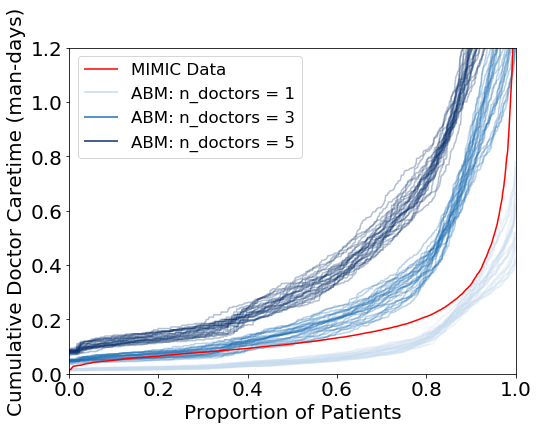

In [707]:
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=1, vmax=5)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(8,6))

for i in range(df_agent_vars['run_number'].max()):
    flat_info = df_agent_vars[df_agent_vars['run_number']==i]
    model_vars = df_model_vars[df_model_vars['run_number']==i][['n_nurses','n_doctors']]
    n_docs = model_vars.iloc[0,:].min()
    cum_caretime_doctors = []
    for j in flat_info['AgentID'].unique():
        cum_caretime_doctors.append(flat_info[flat_info['AgentID']==j]['cum_caretime_doctors'].max())
        
    plt.plot(np.arange(0,1,1/len(cum_caretime_doctors))[:len(cum_caretime_doctors)],sorted(cum_caretime_doctors),
             color=cmap.to_rgba(n_docs + 1),alpha=0.3,label='_')

plt.vlines(2,0,1,color='red',label='MIMIC Data')
    
for n_docs in [1,3,5]:
    plt.vlines(2,0,1,color=cmap.to_rgba(n_docs + 1),label='ABM: n_doctors = '+str(n_docs))

plt.plot(np.arange(0,1,1/len(caretime_info['cum_caretime_doctors'])),
         sorted(caretime_info['cum_caretime_doctors']),color='red')
    
plt.ylim((0,1.2))
plt.xlim(0,1)
plt.xlabel('Proportion of Patients')
plt.ylabel('Cumulative Doctor Caretime (man-days)')
plt.legend(loc='upper left',fontsize='small')
plt.savefig('doctor_caretime_svm.png')
plt.show()

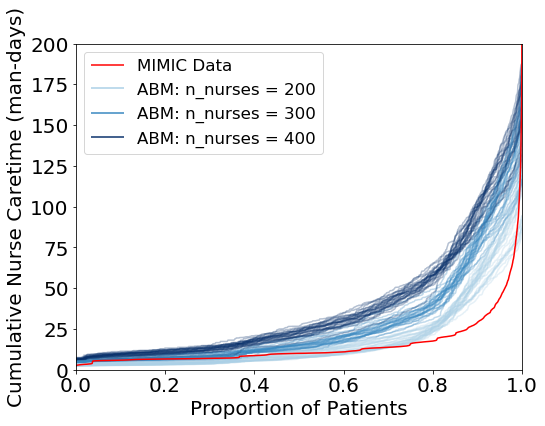

In [708]:
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=100, vmax=400)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(8,6))
quants = np.arange(0,1,1/len(cum_caretime_nurses)) #1/len(cum_caretime_nurses)



for i in range(df_agent_vars['run_number'].max()):
    flat_info = df_agent_vars[df_agent_vars['run_number']==i]
    model_vars = df_model_vars[df_model_vars['run_number']==i][['n_nurses','n_doctors']]
    n_nurses = model_vars.iloc[0,:].max()
    cum_caretime_nurses = []
    for j in flat_info['AgentID'].unique():
        cum_caretime_nurses.append(flat_info[flat_info['AgentID']==j]['cum_caretime_nurses'].max())
    plt.plot(quants,np.quantile(sorted(cum_caretime_nurses),quants),
             color=cmap.to_rgba(n_nurses),alpha=0.3,label='_')

plt.vlines(2,0,1,color='red',label='MIMIC Data')
    
for n_nurse in [200,300,400]:
    plt.vlines(2,0,1,color=cmap.to_rgba(n_nurse),label='ABM: n_nurses = '+str(n_nurse))


plt.plot(np.arange(0,1,1/len(caretime_info['cum_caretime_nurses'])),
         sorted(caretime_info['cum_caretime_nurses']),color='red')
    
plt.ylim((0,200))
plt.xlim(0,1)
plt.xlabel('Proportion of Patients')
plt.ylabel('Cumulative Nurse Caretime (man-days)')
plt.legend(loc='upper left',fontsize='small')
plt.savefig('nurse_caretime_svm.png')
plt.show()

In [577]:
fat_info = fatal_df[['ICUSTAY_ID','LOS']].groupby('ICUSTAY_ID').max()['LOS']

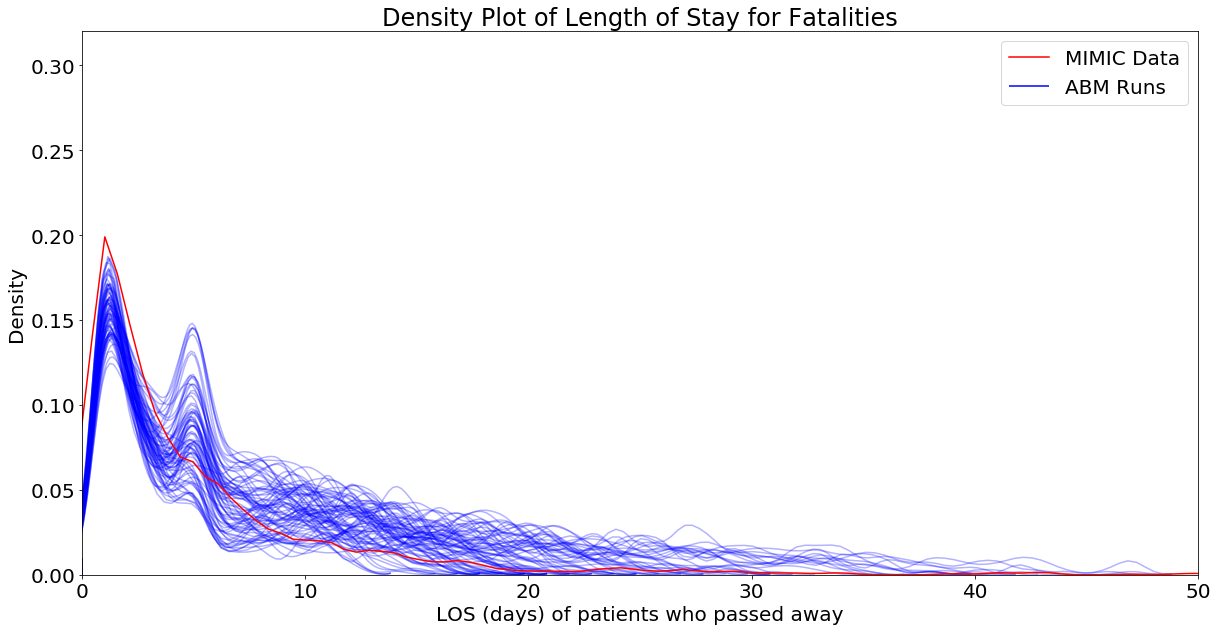

In [630]:
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(20,10))
import seaborn as sns
# Reference Data:
fatal_df=df6[df6["HOSPITAL_EXPIRE_FLAG"]==1] # Fatalities

#ABM Data:
count_deaths_series =[]
for i in range(df_agent_vars['run_number'].max()):
#     data = run_data.loc[i,'all'].get_agent_vars_dataframe()
    flat_info = df_agent_vars[df_agent_vars['run_number']==i]
    flat_info2 = flat_info[flat_info['out_flag']==1] # Fatalities
    count_LOS =[]
    #for j in range(0,len(flat_info2)):
        #count_LOS.append(list(flat_info2.days_in_hospital)[j])
    for j in flat_info2['AgentID'].unique():
        count_LOS.append(flat_info2[flat_info2['AgentID']==j]['days_in_hospital'].max()) 
    sns.kdeplot(count_LOS, bw=.6,color='blue',alpha=0.3)
    #sns.distplot(count_LOS,hist = False, kde = True,
    #             kde_kws = {'shade': True, 'linewidth': 1},color='grey',label='ABM Simulation')
plt.vlines(0,0,0.01, color='blue',label='ABM Runs')
sns.kdeplot(round(fat_info), bw=.6,color='red',label='MIMIC Data')
#sns.distplot(round(fatal_df["LOS"]),hist = False, kde = True,
   #         kde_kws = {'shade': True, 'linewidth': 1},color='blue',label='Actual Data')

#plt.xlim((30,50))
#plt.ylim((0.8,1))
#plt.savefig('LOS_fat_final.png')
plt.title('Density Plot of Length of Stay for Fatalities')
plt.xlabel('LOS (days) of patients who passed away')
plt.ylabel('Density')
plt.legend()
plt.xlim((0,50))
plt.ylim((0,0.32))
plt.savefig('LOS_fat_final.png')
plt.show()

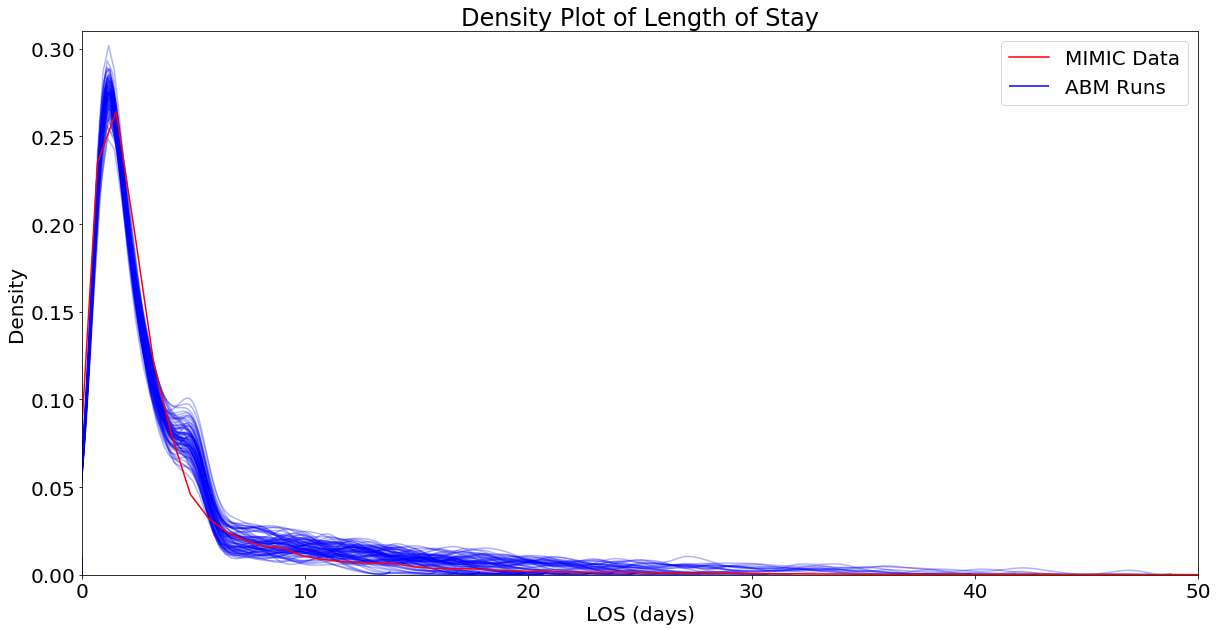

In [588]:
import seaborn as sns

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,10))

count_deaths_series =[]
for i in range(df_agent_vars['run_number'].max()):
    flat_info = df_agent_vars[df_agent_vars['run_number']==i]
    count_LOS =[]

    for j in flat_info['AgentID'].unique():
        count_LOS.append(flat_info[flat_info['AgentID']==j]['days_in_hospital'].max()) 
    sns.kdeplot(count_LOS, bw=.6,color='blue',alpha=0.3)

plt.vlines(0,0,0.01, color='blue',label='ABM Runs')
sns.kdeplot(round(LOS_info), bw=0.6,color='red',label='MIMIC Data')

plt.title('Density Plot of Length of Stay')
plt.xlabel('LOS (days)')
plt.ylabel('Density')
plt.legend()
plt.xlim((0,50))
plt.ylim((0,0.31))
plt.savefig('LOS_all_final.png')
plt.show()

## For XGB submodel

In [ ]:
agent_1 = pd.read_csv("./output/agent_output_1.csv")
agent_2 = pd.read_csv("./output/agent_output_2.csv")
agent_3 = pd.read_csv("./output/agent_output_3.csv")

In [ ]:
model_1 = pd.read_csv("./output/model_output_1.csv")
model_2 = pd.read_csv("./output/model_output_2.csv")
model_3 = pd.read_csv("./output/model_output_3.csv")

In [ ]:
model_2['run_number'] = model_2['run_number']+27
agent_2['run_number'] = agent_2['run_number']+27
model_3['run_number'] = model_3['run_number']+27*2
agent_3['run_number'] = agent_3['run_number']+27*2

In [ ]:
df_model_vars = pd.concat([model_1,model_2,model_3],axis=0)
df_agent_vars = pd.concat([agent_1,agent_2,agent_3],axis=0)

In [ ]:
data = df_agent_vars[df_agent_vars['run_number']==18]
data_model = df_model_vars[df_model_vars['run_number']==18]
cap = data_model['max_agents'].max()
flat_info = pd.DataFrame(data.to_records())

In [ ]:
caretime_info = pd.DataFrame(df3[['ICUSTAY_ID','cum_caretime_doctors','cum_caretime_nurses']]
                             .groupby('ICUSTAY_ID').max().to_records())

In [ ]:
LOS_info = df3[['ICUSTAY_ID','LOS']].groupby('ICUSTAY_ID').max()['LOS']

In [ ]:
fatal_df=df6[df6["HOSPITAL_EXPIRE_FLAG"]==1] # Fatalities

In [ ]:
unit_count1 =[]
for i in range(df_agent_vars['run_number'].max()):
    data = df_agent_vars[df_agent_vars['run_number']==i]
    data_model = df_model_vars[df_model_vars['run_number']==i]
    cap = data_model['max_agents'].max()
    flat_info = pd.DataFrame(data.to_records())
    
    for i in flat_info['Step'].unique():
        unit_count1.append((flat_info[flat_info['Step']==i]['Careunit'].value_counts()/cap*100).to_dict())

unit_count1 = pd.DataFrame(unit_count1)

unit_count_all= unit_count1
unit_count_all['Others']=unit_count_all['Other']
unit_count_all=unit_count_all.drop(columns='Other')

plt.figure(figsize=(8,6))
unit_count_all.boxplot(grid=False)
plt.ylabel("Proportion of beds occupied (% of capacity)")
plt.title("Occupancy of Care Units")
plt.xlabel('Care Units')
plt.savefig('careunit_countpatients2_xgb.png')
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 12})
demand_serviced =[]
n_docs =[]
for i in range(df_model_vars['run_number'].max()):
    data = df_model_vars[df_model_vars['run_number']==i]
    param2 = data[['n_doctors','n_nurses']].iloc[0].min()
    param3 = data['max_agents'].iloc[0]
    n_docs.append(param2)
    flat_info = pd.DataFrame(data.to_records())
    overall_demand_serviced = flat_info['demand_serviced'].iloc[-1] # take the last value as that represent the aggregated demand serviced
    demand_serviced.append(overall_demand_serviced)

sns.stripplot(n_docs,demand_serviced, jitter=0.4)

plt.title('Patient Inflow Being Serviced per n_doctors')
plt.xlabel('Number of Doctors')
plt.ylabel('Demand Serviced')
plt.locator_params(axis='x', nbins=len(np.unique(n_docs)))
plt.savefig('demand_serviced4_xgb.png')
plt.show()

In [ ]:
cols = {80:'blue',100:'orange',120:'green'}
plt.rcParams.update({'font.size': 12})

demand_serviced =[]
max_agents =[]
for i in range(df_model_vars['run_number'].max()):
    data = df_model_vars[df_model_vars['run_number']==i]
    param1 = data[['n_doctors','n_nurses']].iloc[0].max()
    param2 = data[['n_doctors','n_nurses']].iloc[0].min()
    param3 = data['max_agents'].iloc[0]
    max_agents.append(param3)
    flat_info = pd.DataFrame(data.to_records())
    overall_demand_serviced = flat_info['demand_serviced'].iloc[-1] # take the last value as that represent the aggregated demand serviced
    demand_serviced.append(overall_demand_serviced)

color_plot = [cols[m] for m in max_agents]
sns.stripplot(max_agents,demand_serviced, jitter=0.4,palette=['blue','orange','green'])

plt.title('Patient Inflow Being Serviced per max_agents')
plt.xlabel('ICU Maximum Capacity (max_agents)')
plt.ylabel('Demand Serviced')
plt.locator_params(axis='x', nbins=len(np.unique(max_agents)))
#plt.xlim(20,80)
plt.ylim(0.885,1.015)
#plt.legend()
plt.savefig('demand_serviced2_xgb.png')
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 12})
demand_serviced =[]
n_nurses =[]
for i in range(df_model_vars['run_number'].max()):
    data = df_model_vars[df_model_vars['run_number']==i]
    param1 = data[['n_doctors','n_nurses']].iloc[0].max()
    param2 = data[['n_doctors','n_nurses']].iloc[0].min()
    param3 = data['max_agents'].iloc[0]
    n_nurses.append(param1)
    flat_info = pd.DataFrame(data.to_records())
    overall_demand_serviced = flat_info['demand_serviced'].iloc[-1] # take the last value as that represent the aggregated demand serviced
    demand_serviced.append(overall_demand_serviced)
sns.stripplot(n_nurses,demand_serviced, jitter=0.4)

plt.title('Patient Inflow Being Serviced per n_nurses')
plt.xlabel('Number of Nurses')
plt.ylabel('Demand Serviced')
plt.locator_params(axis='x', nbins=len(np.unique(n_nurses)))
plt.savefig('demand_serviced3_xgb.png')
plt.show()

In [ ]:
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=1, vmax=5)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(8,6))

for i in range(df_agent_vars['run_number'].max()):
    flat_info = df_agent_vars[df_agent_vars['run_number']==i]
    model_vars = df_model_vars[df_model_vars['run_number']==i][['n_nurses','n_doctors']]
    n_docs = model_vars.iloc[0,:].min()
    cum_caretime_doctors = []
    for j in flat_info['AgentID'].unique():
        cum_caretime_doctors.append(flat_info[flat_info['AgentID']==j]['cum_caretime_doctors'].max())
        
    plt.plot(np.arange(0,1,1/len(cum_caretime_doctors))[:len(cum_caretime_doctors)],sorted(cum_caretime_doctors),
             color=cmap.to_rgba(n_docs + 1),alpha=0.3,label='_')

plt.vlines(2,0,1,color='red',label='MIMIC Data')
    
for n_docs in [1,3,5]:
    plt.vlines(2,0,1,color=cmap.to_rgba(n_docs + 1),label='ABM: n_doctors = '+str(n_docs))

plt.plot(np.arange(0,1,1/len(caretime_info['cum_caretime_doctors'])),
         sorted(caretime_info['cum_caretime_doctors']),color='red')
    
plt.ylim((0,1.2))
plt.xlim(0,1)
plt.xlabel('Proportion of Patients')
plt.ylabel('Cumulative Doctor Caretime (man-days)')
plt.legend(loc='upper left',fontsize='small')
plt.savefig('doctor_caretime_xgb.png')
plt.show()

In [ ]:
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=100, vmax=400)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])

plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(8,6))
quants = np.arange(0,1,1/len(cum_caretime_nurses)) #1/len(cum_caretime_nurses)



for i in range(df_agent_vars['run_number'].max()):
    flat_info = df_agent_vars[df_agent_vars['run_number']==i]
    model_vars = df_model_vars[df_model_vars['run_number']==i][['n_nurses','n_doctors']]
    n_nurses = model_vars.iloc[0,:].max()
    cum_caretime_nurses = []
    for j in flat_info['AgentID'].unique():
        cum_caretime_nurses.append(flat_info[flat_info['AgentID']==j]['cum_caretime_nurses'].max())
    plt.plot(quants,np.quantile(sorted(cum_caretime_nurses),quants),
             color=cmap.to_rgba(n_nurses),alpha=0.3,label='_')

plt.vlines(2,0,1,color='red',label='MIMIC Data')
    
for n_nurse in [200,300,400]:
    plt.vlines(2,0,1,color=cmap.to_rgba(n_nurse),label='ABM: n_nurses = '+str(n_nurse))


plt.plot(np.arange(0,1,1/len(caretime_info['cum_caretime_nurses'])),
         sorted(caretime_info['cum_caretime_nurses']),color='red')
    
plt.ylim((0,200))
plt.xlim(0,1)
plt.xlabel('Proportion of Patients')
plt.ylabel('Cumulative Nurse Caretime (man-days)')
plt.legend(loc='upper left',fontsize='small')
plt.savefig('nurse_caretime_xgb.png')
plt.show()

In [ ]:
fat_info = fatal_df[['ICUSTAY_ID','LOS']].groupby('ICUSTAY_ID').max()['LOS']

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,10))

# Reference Data:
fatal_df=df6[df6["HOSPITAL_EXPIRE_FLAG"]==1] # Fatalities

#ABM Data:
count_deaths_series =[]
for i in range(df_agent_vars['run_number'].max()):
    flat_info = df_agent_vars[df_agent_vars['run_number']==i]
    flat_info2 = flat_info[flat_info['out_flag']==1] # Fatalities
    count_LOS =[]
    for j in flat_info2['AgentID'].unique():
        count_LOS.append(flat_info2[flat_info2['AgentID']==j]['days_in_hospital'].max()) 
    sns.kdeplot(count_LOS, bw=.6,color='blue',alpha=0.3)
plt.vlines(0,0,0.01, color='blue',label='ABM Runs')
sns.kdeplot(round(fat_info), bw=.6,color='red',label='MIMIC Data')

plt.title('Density Plot of Length of Stay for Fatalities')
plt.xlabel('LOS (days) of patients who passed away')
plt.ylabel('Density')
plt.legend()
plt.xlim((0,50))
plt.ylim((0,0.32))
plt.savefig('LOS_fat_final_xgb.png')
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,10))

# Reference Data:

#ABM Data:
count_deaths_series =[]
for i in range(df_agent_vars['run_number'].max()):
    flat_info = df_agent_vars[df_agent_vars['run_number']==i]
    count_LOS =[]
    for j in flat_info['AgentID'].unique():
        count_LOS.append(flat_info[flat_info['AgentID']==j]['days_in_hospital'].max()) 
    sns.kdeplot(count_LOS, bw=.6,color='blue',alpha=0.3)
plt.vlines(0,0,0.01, color='blue',label='ABM Runs')
sns.kdeplot(round(LOS_info), bw=0.6,color='red',label='MIMIC Data')

plt.title('Density Plot of Length of Stay')
plt.xlabel('LOS (days)')
plt.ylabel('Density')
plt.legend()
plt.xlim((0,50))
plt.ylim((0,0.31))
plt.savefig('LOS_all_final_xgb.png')
plt.show()